## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook.

In [1]:
#!pip install -r requirements.txt

In [2]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

#Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow import random 
from tensorflow.keras import callbacks

sns.set()

---

## Cargar y preparar los datos.

In [3]:
df = pd.read_csv("Datos_finales/Datos_antes_pandemia/data_antes_vol_var_not.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Futuros': 'Vol. Futuros'})
df

Fecha  Vol. Futuros      TRM  Precio Interno        VIX  EMV-ID  \
0    2010-01-01      0.000000  2044.23        695125.0  22.543626    2.01   
1    2010-01-02      4.256365  2044.23        695125.0  22.171185    0.00   
2    2010-01-03      0.794545  2044.23        695125.0  21.143152    1.15   
3    2010-01-04      0.787899  2044.23        705000.0  20.040000    1.22   
4    2010-01-05      0.601027  2021.21        690000.0  19.350000    0.95   
...         ...           ...      ...             ...        ...     ...   
3648 2019-12-27      4.003614  3281.40        995000.0  13.430000    0.00   
3649 2019-12-28      2.090121  3294.05        995000.0  14.351756    0.00   
3650 2019-12-29      0.539108  3294.05        995000.0  14.946538    4.26   
3651 2019-12-30      1.815513  3294.05        991000.0  14.820000    0.97   
3652 2019-12-31      1.871355  3277.14        975000.0  13.780000    1.54   

         EPU  
0     174.55  
1     119.52  
2     216.95  
3     150.35  
4     151.16  
...      ...  
3648  127.92  
3649  123.10  
3650  245.14  
3651  101.31  
3652  105.75  

[3653 rows x 7 columns]

---

## Desarrollo del modelo LSTM

In [4]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [5]:
df_stats=df

In [6]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["Vol. Futuros"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
df_label_normalize=sc.fit_transform(df_label)
df_data_normalize=sc2.fit_transform(df_data)


### Partición de los datos

Se realiza una partición de los datos, de tal manera que el 80% de los primeros registros sean para entrenamiento y el restante sea para probar el modelo. 

In [7]:
#last index of the train data
eight_percent=int(len_data*0.7)

#split the data normalize
df_train=df_data_normalize[:eight_percent]
df_test=df_data_normalize[eight_percent:]

#split labels normalize
df_train_y_normalize=df_label_normalize[:eight_percent]
df_test_y_normalize=df_label_normalize[eight_percent:]

#split the original labels
df_train_y=df_label[:eight_percent]
df_test_y=df_label[eight_percent:]

In [8]:
def plot_metrics(history):
        # plot MAE and loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['loss'], label='loss')
    plt.ylabel("value")
    plt.xlabel("epoch")
    plt.title("error a través de los epochs")
    plt.legend()
    plt.show()

In [9]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [10]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [11]:
def Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons,attributes,epochss,batch_sizze,lag):
    #reshape train data
    lag=lag
    len_df_train=df_train.shape[0]
    X_train=[]
    Y_train=[]
    for i in range(lag,len_df_train):
        X_train.append(df_train[i-lag:i])
        Y_train.append(df_train_y_normalize[i])

    X_train,Y_train=np.array(X_train),np.array(Y_train)
    print(X_train.shape,Y_train.shape)
    
    #reshape test data
    len_df_test=df_test.shape[0]
    X_test=[]
    Y_test=[]
    for i in range(lag,len_df_test):
        X_test.append(df_test[i-lag:i])
        Y_test.append(df_test_y_normalize[i])

    X_test,Y_test=np.array(X_test),np.array(Y_test)
    print(X_test.shape,Y_test.shape)
    
    
    #set the seed
    random.set_seed(7)

    #optional----
    #callback to early stopping and prevent overfitting
    #callback =callbacks.EarlyStopping(monitor='mae', patience=3)

    #make the model
    model=Sequential()
    model.add(LSTM(units=neurons,return_sequences=False,input_shape=(lag,attributes)))
    model.add(Dense(1))
    model.compile(optimizer='adamax',loss='mean_squared_error',metrics=['mae'])
    
    #fit the model with the train data
    history=model.fit(X_train,Y_train,validation_split=0.2,epochs=epochss,batch_size=batch_sizze)
    
    #plot metrics
    plot_metrics(history)
    
    # make predictions
    trainPredict = model.predict(X_train)

    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    model.reset_states()
    testPredict = model.predict(X_test)


    # invert transformation
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:eight_percent],"typeLSTM":["train"]*len(trainPredict.flatten()),"LSTM" :trainPredict.flatten()}
        ,{"Fecha":df_stats.Fecha[eight_percent+lag:],"typeLSTM":["test"]*len(testPredict.flatten()),"LSTM":testPredict.flatten()}]
    
    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()[lag:]+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()[lag:]+1, testPredict.flatten()+1,False)}

(2552, 5, 6) (2552, 1)
(1091, 5, 6) (1091, 1)
Epoch 1/100
128/128 [==============================] - 3s 8ms/step - loss: 1.1656 - mae: 0.7682 - val_loss: 0.8141 - val_mae: 0.7071
Epoch 2/100
128/128 [==============================] - 1s 4ms/step - loss: 1.1451 - mae: 0.7639 - val_loss: 0.8181 - val_mae: 0.7128
Epoch 3/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1347 - mae: 0.7640 - val_loss: 0.8225 - val_mae: 0.7178
Epoch 4/100
128/128 [==============================] - 1s 4ms/step - loss: 1.1281 - mae: 0.7631 - val_loss: 0.8230 - val_mae: 0.7186
Epoch 5/100
128/128 [==============================] - 1s 4ms/step - loss: 1.1233 - mae: 0.7611 - val_loss: 0.8231 - val_mae: 0.7185
Epoch 6/100
128/128 [==============================] - 1s 4ms/step - loss: 1.1196 - mae: 0.7637 - val_loss: 0.8237 - val_mae: 0.7193
Epoch 7/100
128/128 [==============================] - 1s 4ms/step - loss: 1.1160 - mae: 0.7621 - val_loss: 0.8220 - val_mae: 0.7179
Epoch 8/100
128/128 [==

Epoch 62/100
128/128 [==============================] - 1s 4ms/step - loss: 1.0471 - mae: 0.7420 - val_loss: 0.7951 - val_mae: 0.6923
Epoch 63/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0454 - mae: 0.7439 - val_loss: 0.7947 - val_mae: 0.6914
Epoch 64/100
128/128 [==============================] - 1s 4ms/step - loss: 1.0454 - mae: 0.7421 - val_loss: 0.7943 - val_mae: 0.6903
Epoch 65/100
128/128 [==============================] - 1s 4ms/step - loss: 1.0436 - mae: 0.7399 - val_loss: 0.7944 - val_mae: 0.6906
Epoch 66/100
128/128 [==============================] - 1s 4ms/step - loss: 1.0428 - mae: 0.7413 - val_loss: 0.7947 - val_mae: 0.6908
Epoch 67/100
128/128 [==============================] - 1s 4ms/step - loss: 1.0418 - mae: 0.7429 - val_loss: 0.7953 - val_mae: 0.6911
Epoch 68/100
128/128 [==============================] - 1s 4ms/step - loss: 1.0406 - mae: 0.7401 - val_loss: 0.7946 - val_mae: 0.6903
Epoch 69/100
128/128 [==============================] - 1s 4ms

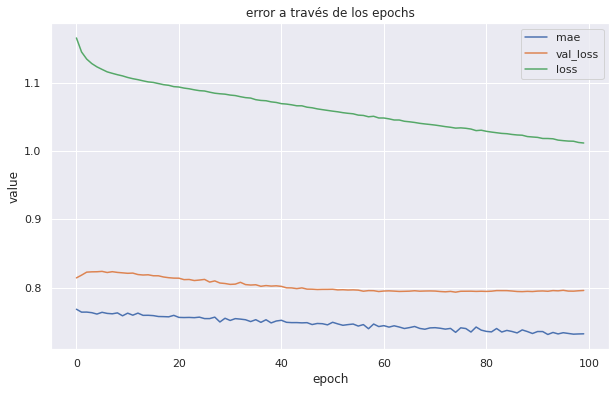

35/35 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.25240421946504
MAE is : 0.8192132412572064
RMSE is : 1.1191086718746486
MAPE is : 40.49626294867208
Evaluation metric results:
MSE is : 1.0328242501683051
MAE is : 0.8051546963725098
RMSE is : 1.016279612197502
MAPE is : 45.45766147759805
(2552, 5, 6) (2552, 1)
(1091, 5, 6) (1091, 1)
Epoch 1/100
128/128 [==============================] - 3s 9ms/step - loss: 1.1288 - mae: 0.7613 - val_loss: 0.8084 - val_mae: 0.7058
Epoch 2/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1151 - mae: 0.7622 - val_loss: 0.8074 - val_mae: 0.7058
Epoch 3/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1095 - mae: 0.7624 - val_loss: 0.8078 - val_mae: 0.7071
Epoch 4/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1062 - mae: 0.7603 - val_loss: 0.8057 - val_mae: 0.7059
Epoch 5/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1033 - mae: 0.7

128/128 [==============================] - 1s 5ms/step - loss: 1.0318 - mae: 0.7418 - val_loss: 0.7928 - val_mae: 0.6808
Epoch 60/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0274 - mae: 0.7371 - val_loss: 0.7918 - val_mae: 0.6795
Epoch 61/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0275 - mae: 0.7392 - val_loss: 0.7937 - val_mae: 0.6811
Epoch 62/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0257 - mae: 0.7363 - val_loss: 0.7936 - val_mae: 0.6801
Epoch 63/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0230 - mae: 0.7384 - val_loss: 0.7937 - val_mae: 0.6804
Epoch 64/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0232 - mae: 0.7350 - val_loss: 0.7934 - val_mae: 0.6793
Epoch 65/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0208 - mae: 0.7350 - val_loss: 0.7936 - val_mae: 0.6781
Epoch 66/100
128/128 [==============================] - 1s 5ms/step - loss:

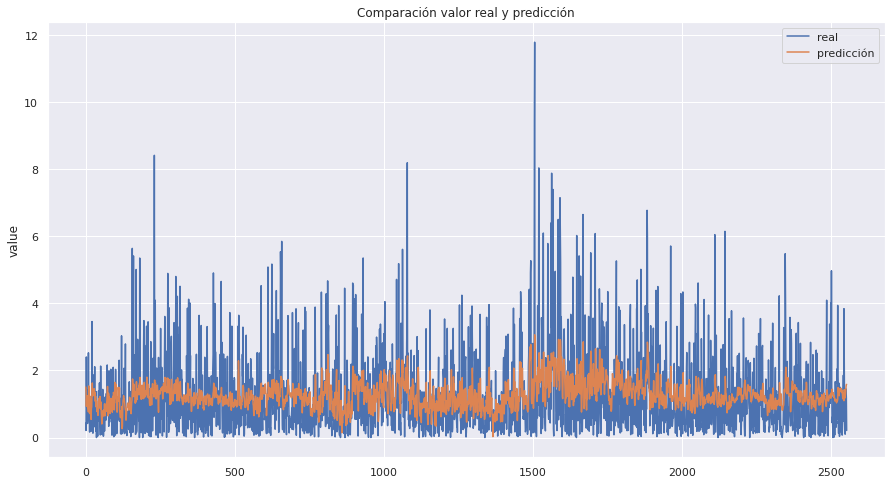

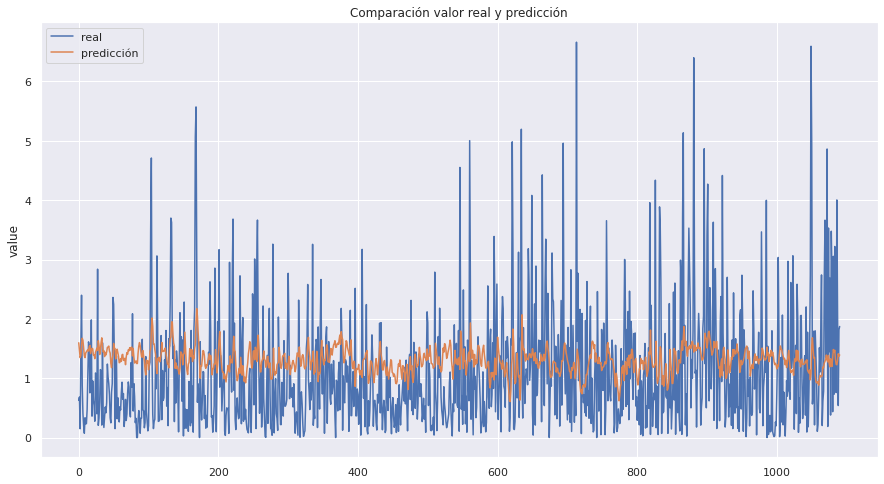

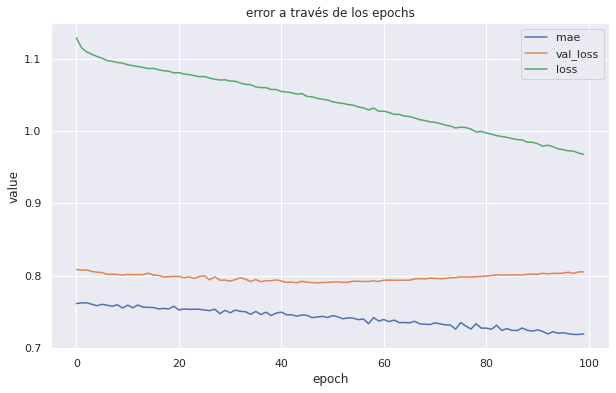

35/35 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.2052539710275654
MAE is : 0.8036030991377673
RMSE is : 1.0978405945434726
MAPE is : 39.39930628476209
Evaluation metric results:
MSE is : 1.0706070875257157
MAE is : 0.8137448550841273
RMSE is : 1.034701448498897
MAPE is : 45.14667144960459
(2552, 5, 6) (2552, 1)
(1091, 5, 6) (1091, 1)
Epoch 1/100
128/128 [==============================] - 3s 10ms/step - loss: 1.1429 - mae: 0.7705 - val_loss: 0.7859 - val_mae: 0.6764
Epoch 2/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1228 - mae: 0.7650 - val_loss: 0.7832 - val_mae: 0.6778
Epoch 3/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1150 - mae: 0.7641 - val_loss: 0.7835 - val_mae: 0.6822
Epoch 4/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1106 - mae: 0.7617 - val_loss: 0.7816 - val_mae: 0.6831
Epoch 5/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1069 - mae: 

Epoch 59/100
128/128 [==============================] - 1s 5ms/step - loss: 0.9966 - mae: 0.7303 - val_loss: 0.7929 - val_mae: 0.6845
Epoch 60/100
128/128 [==============================] - 1s 5ms/step - loss: 0.9898 - mae: 0.7248 - val_loss: 0.7969 - val_mae: 0.6872
Epoch 61/100
128/128 [==============================] - 1s 6ms/step - loss: 0.9881 - mae: 0.7258 - val_loss: 0.8037 - val_mae: 0.6921
Epoch 62/100
128/128 [==============================] - 1s 5ms/step - loss: 0.9864 - mae: 0.7229 - val_loss: 0.8017 - val_mae: 0.6893
Epoch 63/100
128/128 [==============================] - 1s 5ms/step - loss: 0.9807 - mae: 0.7239 - val_loss: 0.8066 - val_mae: 0.6930
Epoch 64/100
128/128 [==============================] - 1s 5ms/step - loss: 0.9819 - mae: 0.7209 - val_loss: 0.8047 - val_mae: 0.6900
Epoch 65/100
128/128 [==============================] - 1s 5ms/step - loss: 0.9779 - mae: 0.7210 - val_loss: 0.8040 - val_mae: 0.6893
Epoch 66/100
128/128 [==============================] - 1s 5ms

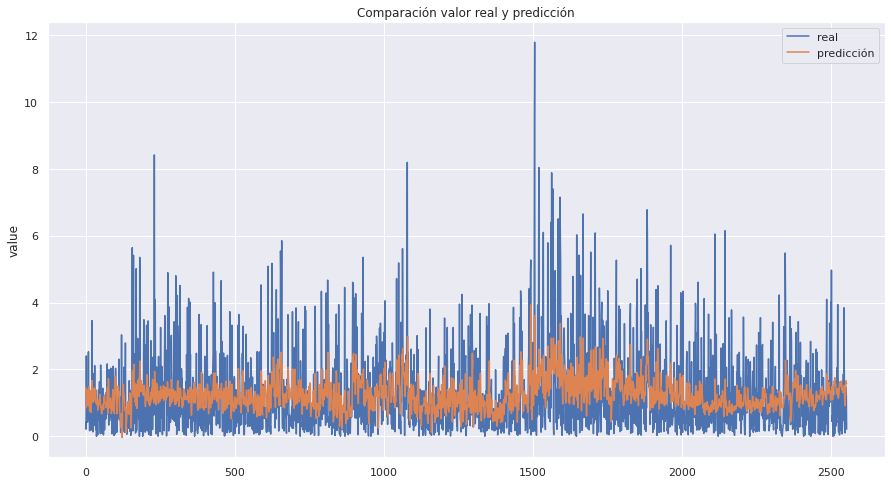

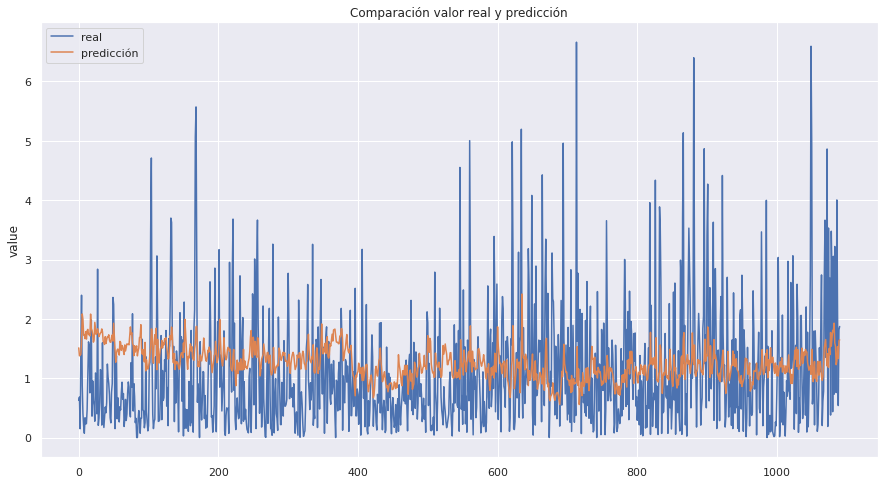

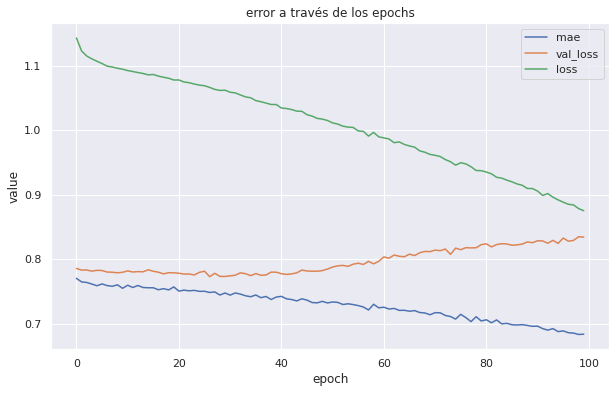

35/35 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.1126149620356725
MAE is : 0.7731867004549107
RMSE is : 1.0548056513100754
MAPE is : 38.26850978789827
Evaluation metric results:
MSE is : 1.0658463205498963
MAE is : 0.80939494907578
RMSE is : 1.0323983342440535
MAPE is : 44.991087775105726
(2552, 5, 6) (2552, 1)
(1091, 5, 6) (1091, 1)
Epoch 1/100
128/128 [==============================] - 4s 11ms/step - loss: 1.1383 - mae: 0.7691 - val_loss: 0.8062 - val_mae: 0.7083
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1182 - mae: 0.7658 - val_loss: 0.7978 - val_mae: 0.7032
Epoch 3/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1102 - mae: 0.7641 - val_loss: 0.7965 - val_mae: 0.7033
Epoch 4/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1052 - mae: 0.7611 - val_loss: 0.7934 - val_mae: 0.7014
Epoch 5/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1038 - mae: 

Epoch 59/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9756 - mae: 0.7216 - val_loss: 0.8307 - val_mae: 0.7070
Epoch 60/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9649 - mae: 0.7159 - val_loss: 0.8358 - val_mae: 0.7116
Epoch 61/100
128/128 [==============================] - 1s 8ms/step - loss: 0.9617 - mae: 0.7157 - val_loss: 0.8456 - val_mae: 0.7193
Epoch 62/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9619 - mae: 0.7120 - val_loss: 0.8444 - val_mae: 0.7172
Epoch 63/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9530 - mae: 0.7106 - val_loss: 0.8488 - val_mae: 0.7202
Epoch 64/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9546 - mae: 0.7098 - val_loss: 0.8380 - val_mae: 0.7103
Epoch 65/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9523 - mae: 0.7101 - val_loss: 0.8428 - val_mae: 0.7164
Epoch 66/100
128/128 [==============================] - 1s 7ms

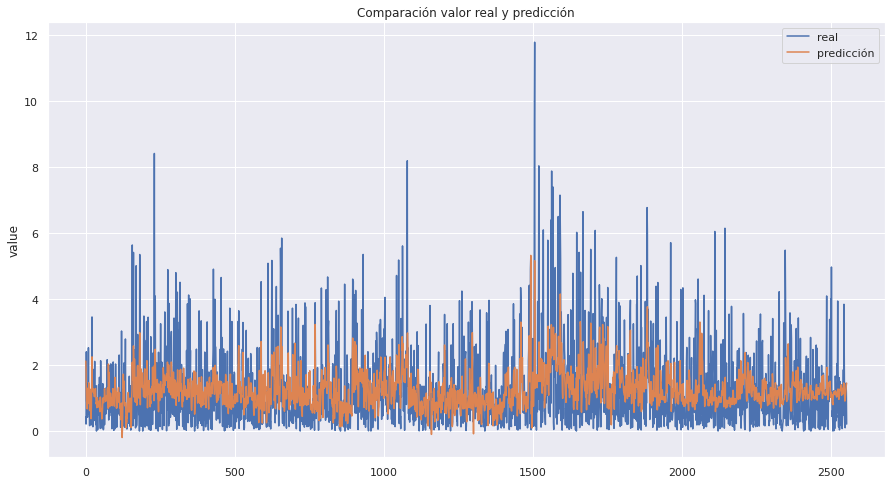

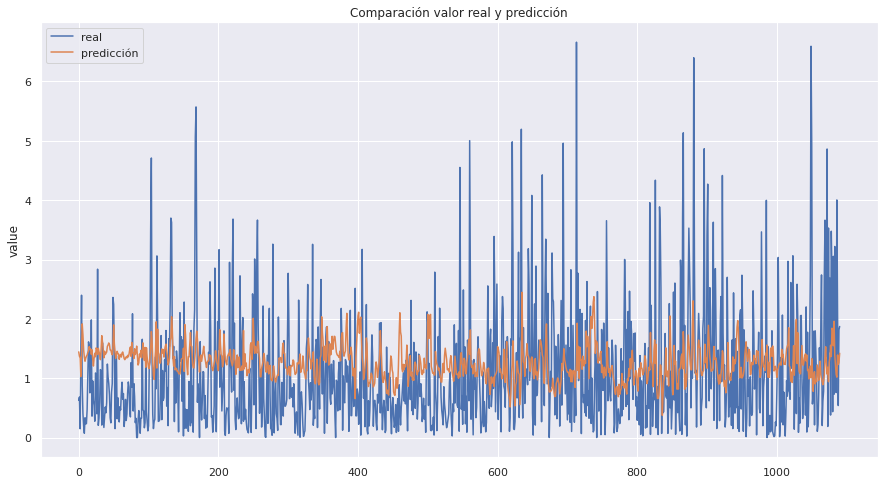

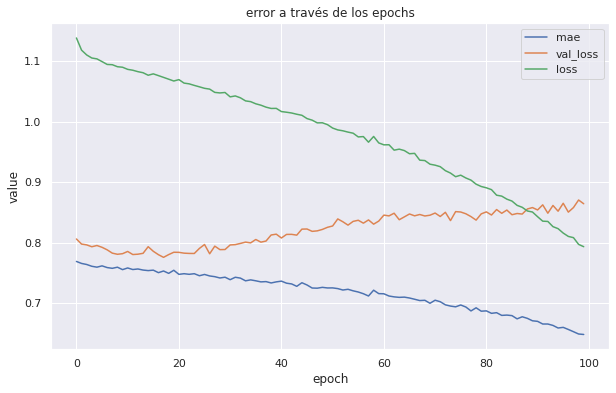

35/35 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.0216318795117125
MAE is : 0.7406463582196283
RMSE is : 1.0107580717024784
MAPE is : 36.900157991602576
Evaluation metric results:
MSE is : 1.1439657831031718
MAE is : 0.8539895089484822
RMSE is : 1.0695633609577189
MAPE is : 48.78928602453267
(2552, 5, 6) (2552, 1)
(1091, 5, 6) (1091, 1)
Epoch 1/100
128/128 [==============================] - 4s 16ms/step - loss: 1.1395 - mae: 0.7706 - val_loss: 0.7967 - val_mae: 0.7019
Epoch 2/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1187 - mae: 0.7656 - val_loss: 0.7852 - val_mae: 0.6941
Epoch 3/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1095 - mae: 0.7631 - val_loss: 0.7856 - val_mae: 0.6955
Epoch 4/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1035 - mae: 0.7609 - val_loss: 0.7847 - val_mae: 0.6945
Epoch 5/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1037 -

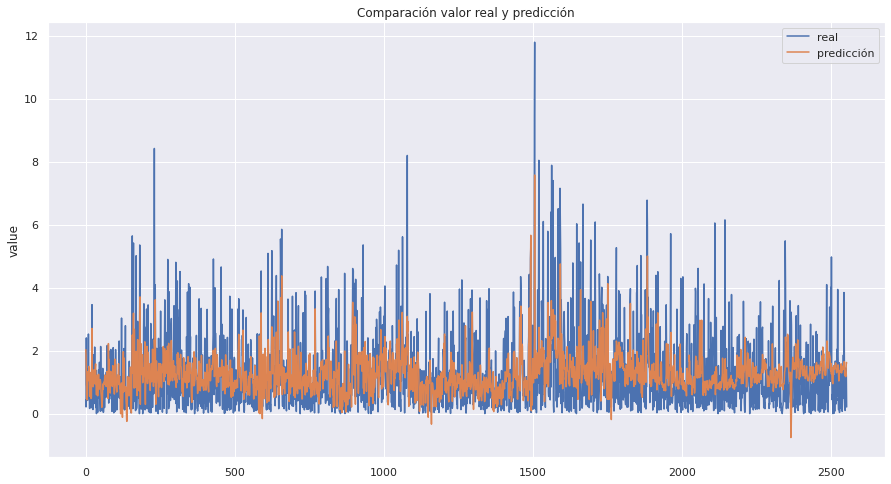

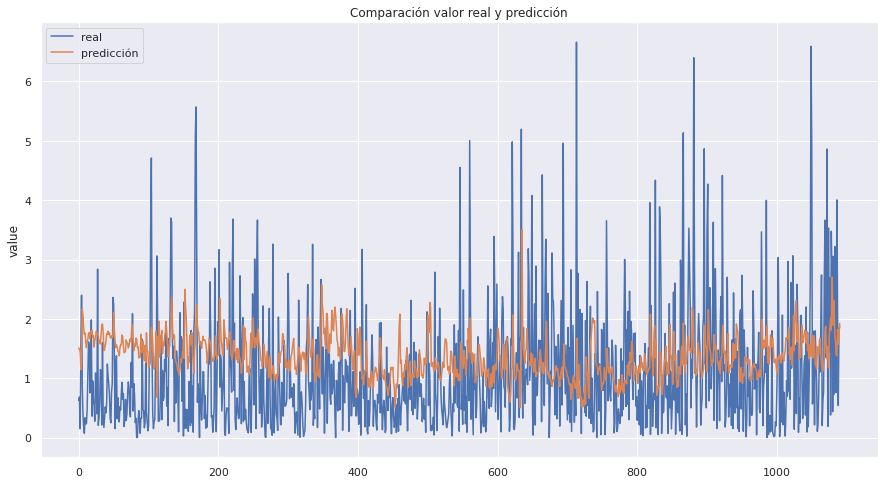

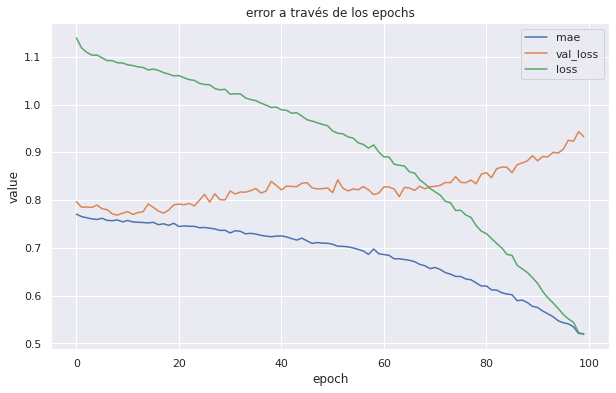

35/35 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 0.7278041731770163
MAE is : 0.6147170247766027
RMSE is : 0.8531143963015841
MAPE is : 31.17963150551068
Evaluation metric results:
MSE is : 1.3374212420773284
MAE is : 0.9025725434921814
RMSE is : 1.1564693001015325
MAPE is : 50.02582198169239
(2552, 5, 6) (2552, 1)
(1091, 5, 6) (1091, 1)
Epoch 1/100
128/128 [==============================] - 5s 25ms/step - loss: 1.1405 - mae: 0.7709 - val_loss: 0.8025 - val_mae: 0.7123
Epoch 2/100
128/128 [==============================] - 3s 21ms/step - loss: 1.1176 - mae: 0.7658 - val_loss: 0.7792 - val_mae: 0.6953
Epoch 3/100
128/128 [==============================] - 3s 21ms/step - loss: 1.1062 - mae: 0.7617 - val_loss: 0.7751 - val_mae: 0.6921
Epoch 4/100
128/128 [==============================] - 3s 20ms/step - loss: 1.0982 - mae: 0.7589 - val_loss: 0.7737 - val_mae: 0.6888
Epoch 5/100
128/128 [==============================] - 3s 20ms/step - loss: 1.0996 - 

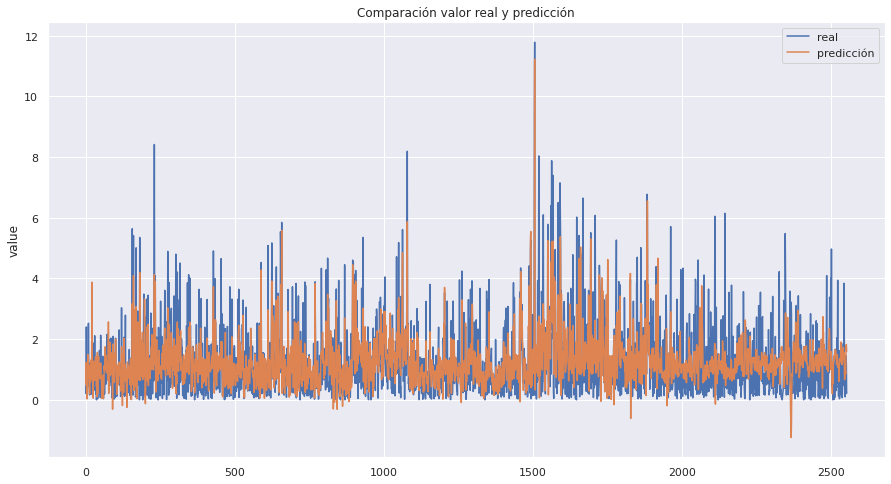

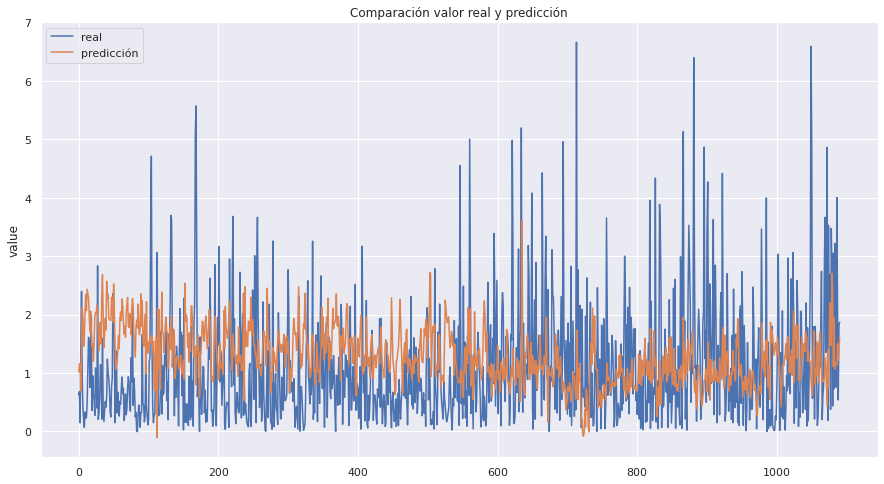

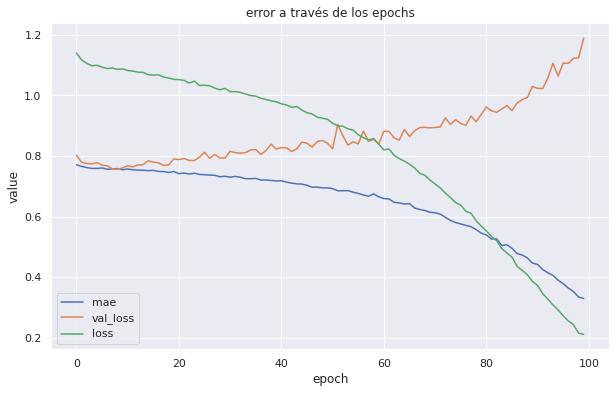

35/35 [==============================] - 0s 8ms/step
Evaluation metric results:
MSE is : 0.4874393187708164
MAE is : 0.4551819992774978
RMSE is : 0.6981685461053201
MAPE is : 22.618789715563818
Evaluation metric results:
MSE is : 1.4925063434851065
MAE is : 0.9159852596219964
RMSE is : 1.221681768499926
MAPE is : 48.221752452857885
(2549, 8, 6) (2549, 1)
(1088, 8, 6) (1088, 1)
Epoch 1/100
128/128 [==============================] - 3s 10ms/step - loss: 1.1370 - mae: 0.7590 - val_loss: 0.8003 - val_mae: 0.6798
Epoch 2/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1156 - mae: 0.7605 - val_loss: 0.7998 - val_mae: 0.6842
Epoch 3/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1103 - mae: 0.7626 - val_loss: 0.7991 - val_mae: 0.6830
Epoch 4/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1060 - mae: 0.7613 - val_loss: 0.7990 - val_mae: 0.6821
Epoch 5/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1027 - mae

Epoch 59/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0275 - mae: 0.7325 - val_loss: 0.8409 - val_mae: 0.6653
Epoch 60/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0269 - mae: 0.7318 - val_loss: 0.8414 - val_mae: 0.6652
Epoch 61/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0269 - mae: 0.7341 - val_loss: 0.8414 - val_mae: 0.6656
Epoch 62/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0245 - mae: 0.7343 - val_loss: 0.8425 - val_mae: 0.6656
Epoch 63/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0238 - mae: 0.7319 - val_loss: 0.8433 - val_mae: 0.6652
Epoch 64/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0226 - mae: 0.7350 - val_loss: 0.8448 - val_mae: 0.6650
Epoch 65/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0221 - mae: 0.7312 - val_loss: 0.8452 - val_mae: 0.6649
Epoch 66/100
128/128 [==============================] - 1s 6ms

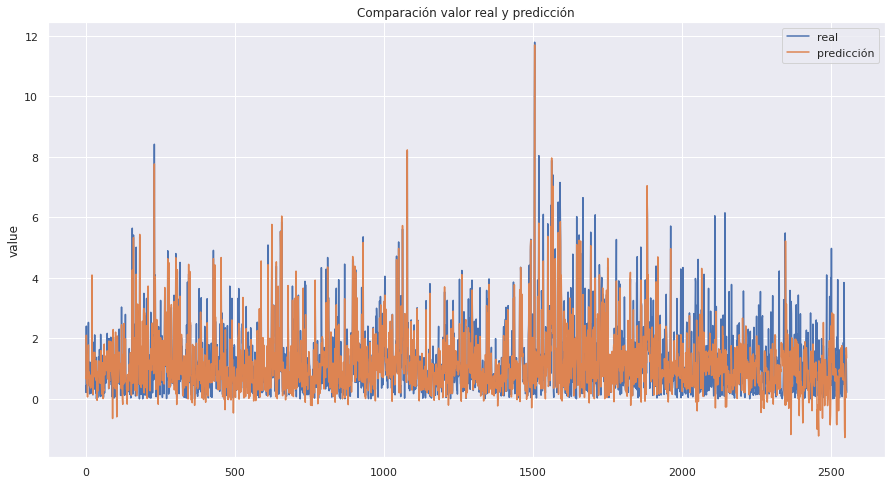

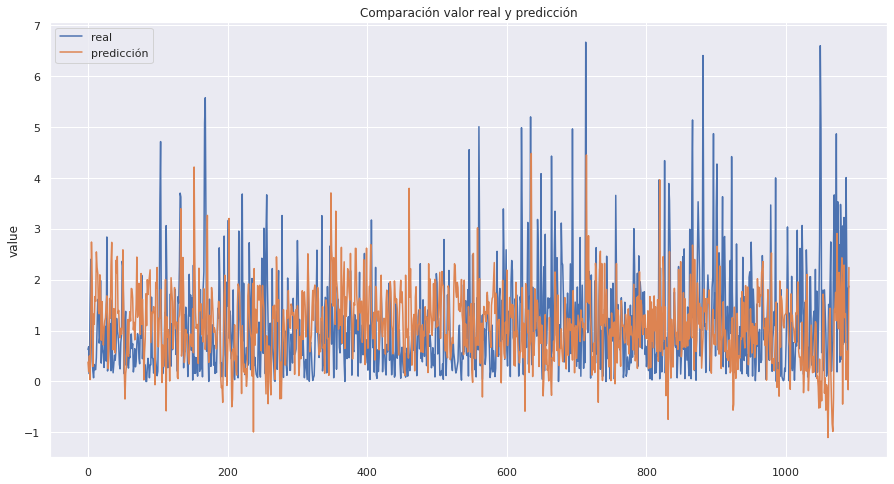

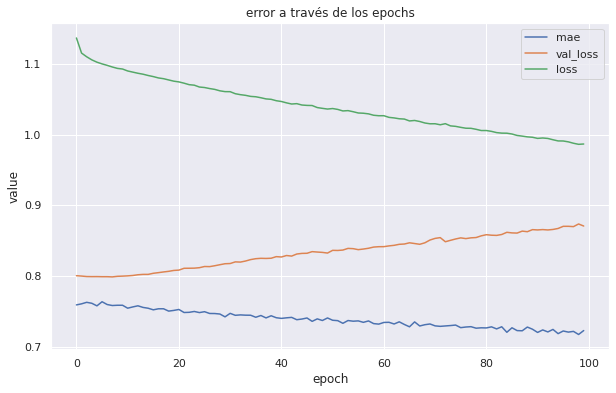

34/34 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.242687171045806
MAE is : 0.8025280700490653
RMSE is : 1.1147587950071558
MAPE is : 38.43054288508955
Evaluation metric results:
MSE is : 1.0436099889467478
MAE is : 0.7427500661939292
RMSE is : 1.0215723121476756
MAPE is : 36.90563278840388
(2549, 8, 6) (2549, 1)
(1088, 8, 6) (1088, 1)
Epoch 1/100
128/128 [==============================] - 3s 10ms/step - loss: 1.1660 - mae: 0.7733 - val_loss: 0.8077 - val_mae: 0.6948
Epoch 2/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1373 - mae: 0.7678 - val_loss: 0.8100 - val_mae: 0.7005
Epoch 3/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1248 - mae: 0.7667 - val_loss: 0.8053 - val_mae: 0.6976
Epoch 4/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1157 - mae: 0.7636 - val_loss: 0.8054 - val_mae: 0.6978
Epoch 5/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1092 - mae: 

Epoch 59/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0091 - mae: 0.7265 - val_loss: 0.8355 - val_mae: 0.6733
Epoch 60/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0083 - mae: 0.7256 - val_loss: 0.8378 - val_mae: 0.6733
Epoch 61/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0098 - mae: 0.7294 - val_loss: 0.8365 - val_mae: 0.6752
Epoch 62/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0044 - mae: 0.7283 - val_loss: 0.8381 - val_mae: 0.6728
Epoch 63/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0035 - mae: 0.7247 - val_loss: 0.8393 - val_mae: 0.6739
Epoch 64/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0009 - mae: 0.7288 - val_loss: 0.8401 - val_mae: 0.6737
Epoch 65/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0027 - mae: 0.7250 - val_loss: 0.8401 - val_mae: 0.6744
Epoch 66/100
128/128 [==============================] - 1s 6ms

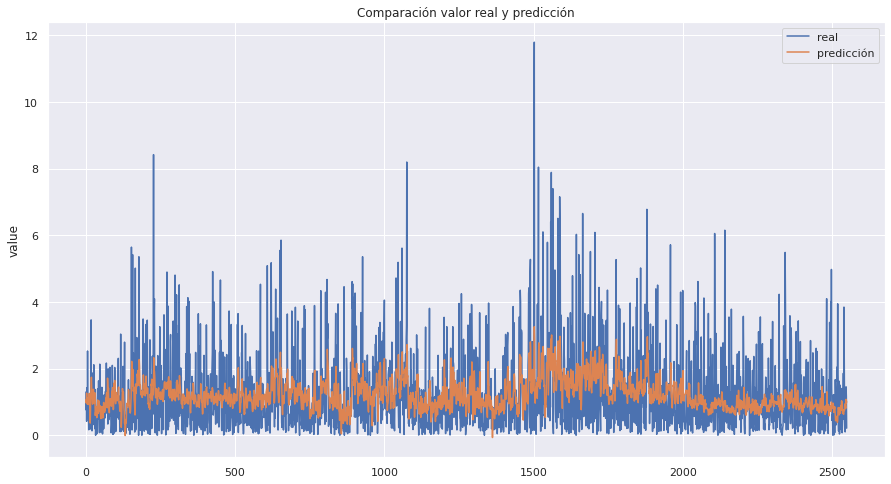

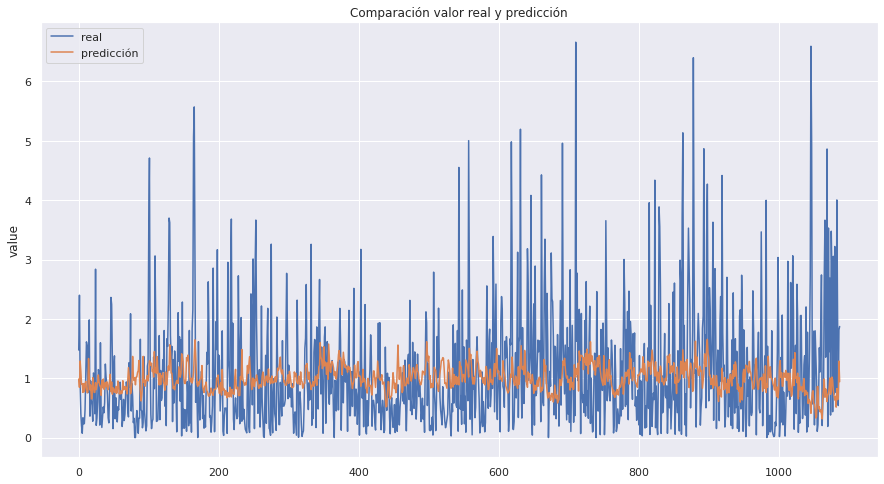

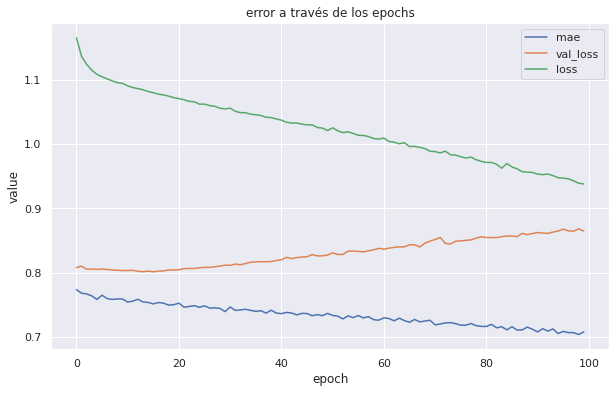

34/34 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.1871265513620195
MAE is : 0.7861120418196686
RMSE is : 1.089553372424692
MAPE is : 37.61924070283261
Evaluation metric results:
MSE is : 1.1020593180006113
MAE is : 0.7844182809886966
RMSE is : 1.0497901304549455
MAPE is : 40.36838096216459
(2549, 8, 6) (2549, 1)
(1088, 8, 6) (1088, 1)
Epoch 1/100
128/128 [==============================] - 3s 11ms/step - loss: 1.1477 - mae: 0.7660 - val_loss: 0.7930 - val_mae: 0.6828
Epoch 2/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1227 - mae: 0.7648 - val_loss: 0.7991 - val_mae: 0.6902
Epoch 3/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1169 - mae: 0.7638 - val_loss: 0.7928 - val_mae: 0.6808
Epoch 4/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1120 - mae: 0.7633 - val_loss: 0.7949 - val_mae: 0.6871
Epoch 5/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1054 - mae: 

Epoch 59/100
128/128 [==============================] - 1s 6ms/step - loss: 0.9670 - mae: 0.7116 - val_loss: 0.8262 - val_mae: 0.7026
Epoch 60/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9657 - mae: 0.7095 - val_loss: 0.8262 - val_mae: 0.6992
Epoch 61/100
128/128 [==============================] - 1s 6ms/step - loss: 0.9661 - mae: 0.7126 - val_loss: 0.8294 - val_mae: 0.7027
Epoch 62/100
128/128 [==============================] - 1s 6ms/step - loss: 0.9587 - mae: 0.7102 - val_loss: 0.8305 - val_mae: 0.7048
Epoch 63/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9544 - mae: 0.7044 - val_loss: 0.8330 - val_mae: 0.7063
Epoch 64/100
128/128 [==============================] - 1s 6ms/step - loss: 0.9512 - mae: 0.7103 - val_loss: 0.8342 - val_mae: 0.7047
Epoch 65/100
128/128 [==============================] - 1s 6ms/step - loss: 0.9532 - mae: 0.7070 - val_loss: 0.8357 - val_mae: 0.7053
Epoch 66/100
128/128 [==============================] - 1s 7ms

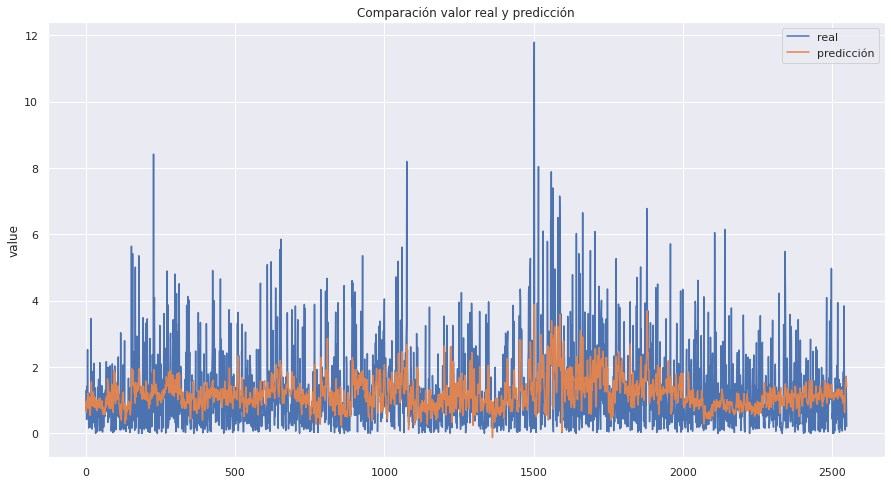

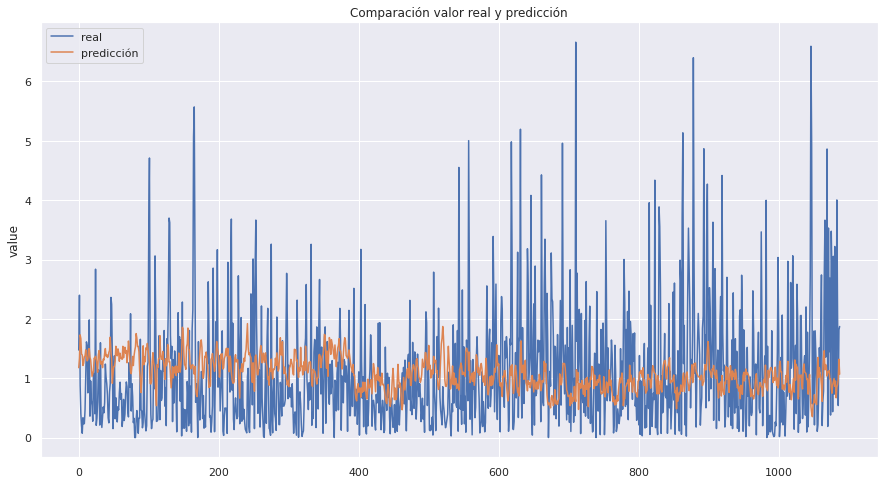

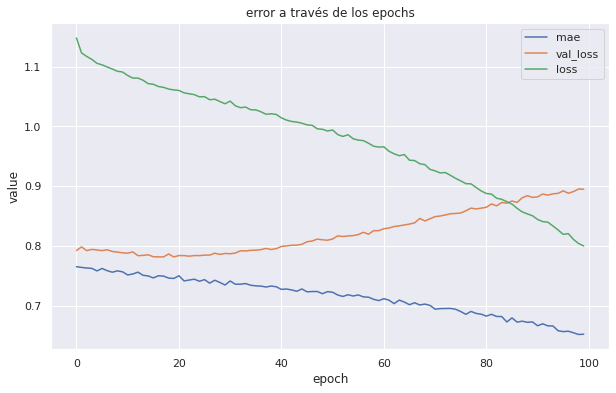

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.0401128468512189
MAE is : 0.7452529175185033
RMSE is : 1.0198592289385917
MAPE is : 36.32631546439548
Evaluation metric results:
MSE is : 1.0800893779814917
MAE is : 0.7993273278758233
RMSE is : 1.0392734856530748
MAPE is : 43.03151807601222
(2549, 8, 6) (2549, 1)
(1088, 8, 6) (1088, 1)
Epoch 1/100
128/128 [==============================] - 4s 13ms/step - loss: 1.1407 - mae: 0.7683 - val_loss: 0.7877 - val_mae: 0.6766
Epoch 2/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1170 - mae: 0.7627 - val_loss: 0.7950 - val_mae: 0.6853
Epoch 3/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1133 - mae: 0.7624 - val_loss: 0.7856 - val_mae: 0.6766
Epoch 4/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1073 - mae: 0.7621 - val_loss: 0.7902 - val_mae: 0.6910
Epoch 5/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0987 - mae:

Epoch 59/100
128/128 [==============================] - 1s 8ms/step - loss: 0.8656 - mae: 0.6723 - val_loss: 0.8408 - val_mae: 0.7078
Epoch 60/100
128/128 [==============================] - 1s 8ms/step - loss: 0.8589 - mae: 0.6682 - val_loss: 0.8425 - val_mae: 0.7061
Epoch 61/100
128/128 [==============================] - 1s 8ms/step - loss: 0.8590 - mae: 0.6714 - val_loss: 0.8470 - val_mae: 0.7059
Epoch 62/100
128/128 [==============================] - 1s 9ms/step - loss: 0.8449 - mae: 0.6645 - val_loss: 0.8428 - val_mae: 0.7055
Epoch 63/100
128/128 [==============================] - 1s 9ms/step - loss: 0.8323 - mae: 0.6588 - val_loss: 0.8464 - val_mae: 0.7105
Epoch 64/100
128/128 [==============================] - 1s 8ms/step - loss: 0.8241 - mae: 0.6618 - val_loss: 0.8519 - val_mae: 0.7087
Epoch 65/100
128/128 [==============================] - 1s 9ms/step - loss: 0.8233 - mae: 0.6577 - val_loss: 0.8575 - val_mae: 0.7143
Epoch 66/100
128/128 [==============================] - 1s 9ms

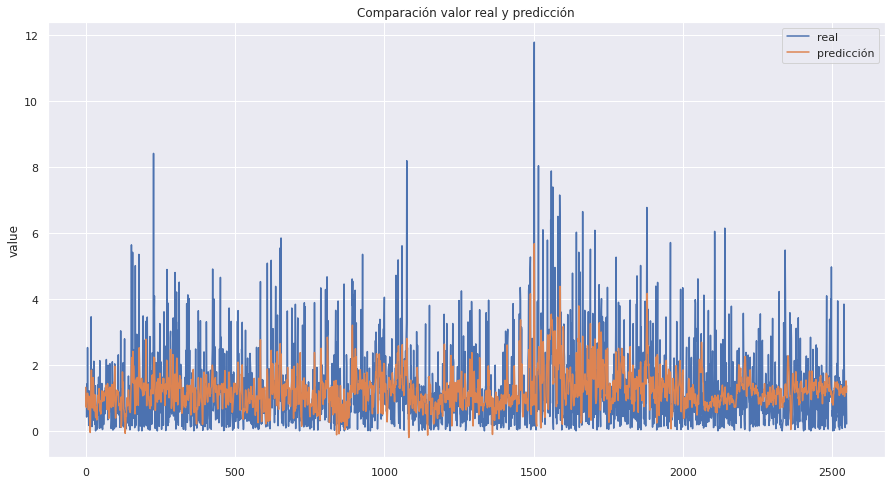

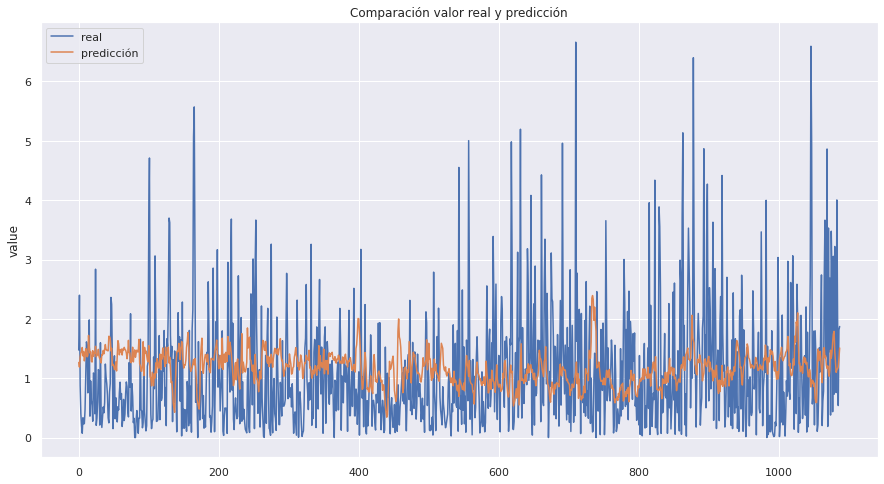

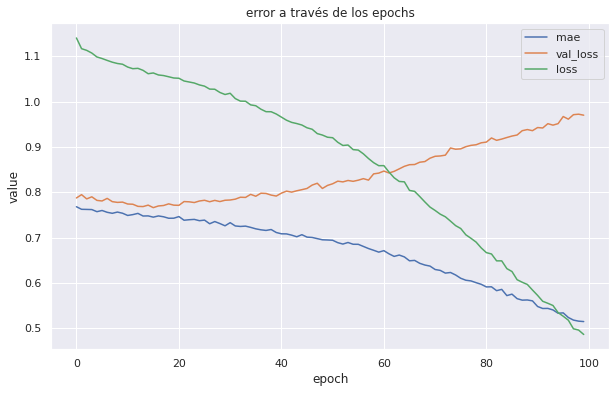

34/34 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 0.7168641244841751
MAE is : 0.6130553511781576
RMSE is : 0.8466782886576076
MAPE is : 30.551708172878566
Evaluation metric results:
MSE is : 1.1535770072518696
MAE is : 0.8057788424966197
RMSE is : 1.0740470228308767
MAPE is : 41.70900304751446
(2549, 8, 6) (2549, 1)
(1088, 8, 6) (1088, 1)
Epoch 1/100
128/128 [==============================] - 4s 18ms/step - loss: 1.1523 - mae: 0.7747 - val_loss: 0.8049 - val_mae: 0.7008
Epoch 2/100
128/128 [==============================] - 2s 15ms/step - loss: 1.1251 - mae: 0.7655 - val_loss: 0.7989 - val_mae: 0.6952
Epoch 3/100
128/128 [==============================] - 2s 14ms/step - loss: 1.1170 - mae: 0.7636 - val_loss: 0.7815 - val_mae: 0.6816
Epoch 4/100
128/128 [==============================] - 2s 14ms/step - loss: 1.1078 - mae: 0.7609 - val_loss: 0.7926 - val_mae: 0.7018
Epoch 5/100
128/128 [==============================] - 2s 14ms/step - loss: 1.0963 -

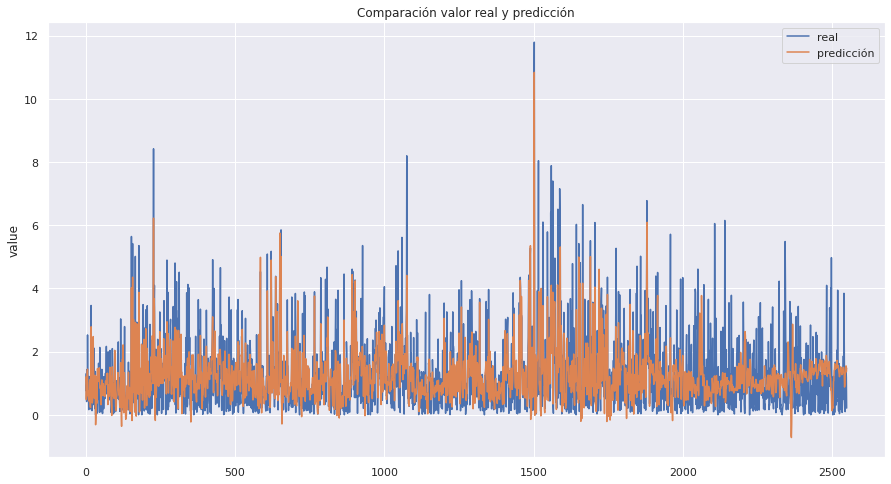

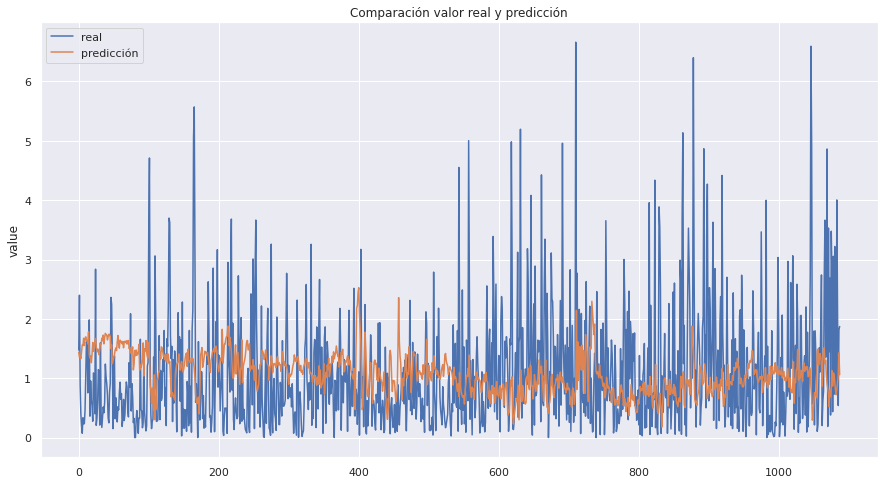

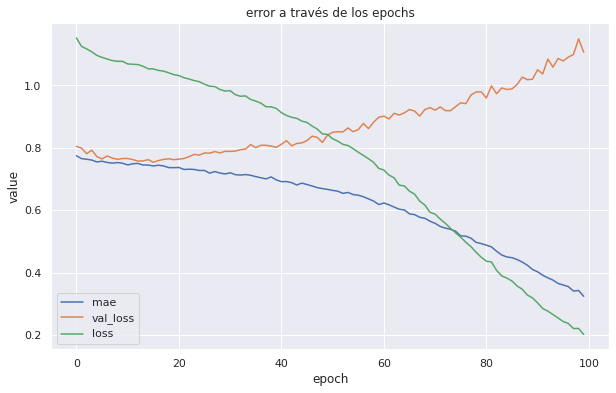

34/34 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 0.484514772330468
MAE is : 0.46873666114086865
RMSE is : 0.6960709535172891
MAPE is : 23.605696401656633
Evaluation metric results:
MSE is : 1.2768447801264344
MAE is : 0.8293860396246853
RMSE is : 1.1299755661634612
MAPE is : 41.79885613398916
(2549, 8, 6) (2549, 1)
(1088, 8, 6) (1088, 1)
Epoch 1/100
128/128 [==============================] - 6s 30ms/step - loss: 1.1402 - mae: 0.7690 - val_loss: 0.7819 - val_mae: 0.6840
Epoch 2/100
128/128 [==============================] - 3s 26ms/step - loss: 1.1131 - mae: 0.7611 - val_loss: 0.7783 - val_mae: 0.6753
Epoch 3/100
128/128 [==============================] - 3s 27ms/step - loss: 1.1061 - mae: 0.7598 - val_loss: 0.7633 - val_mae: 0.6749
Epoch 4/100
128/128 [==============================] - 3s 26ms/step - loss: 1.0987 - mae: 0.7587 - val_loss: 0.7704 - val_mae: 0.6915
Epoch 5/100
128/128 [==============================] - 3s 27ms/step - loss: 1.0897 -

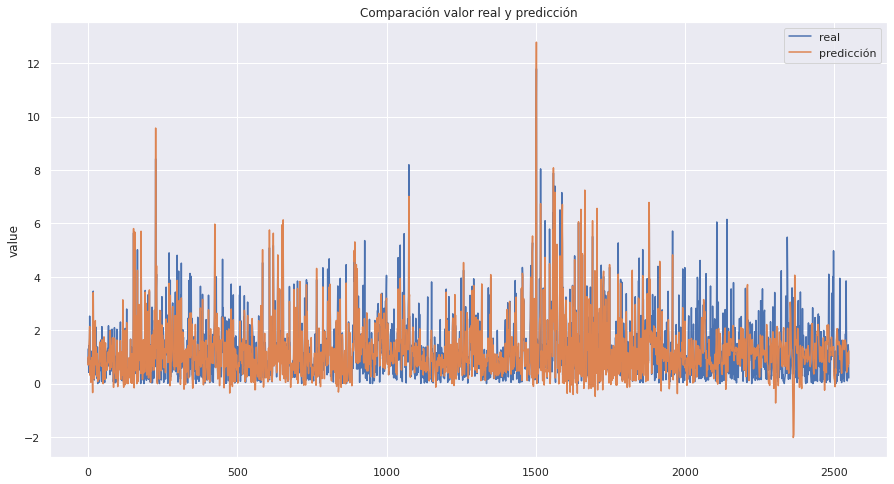

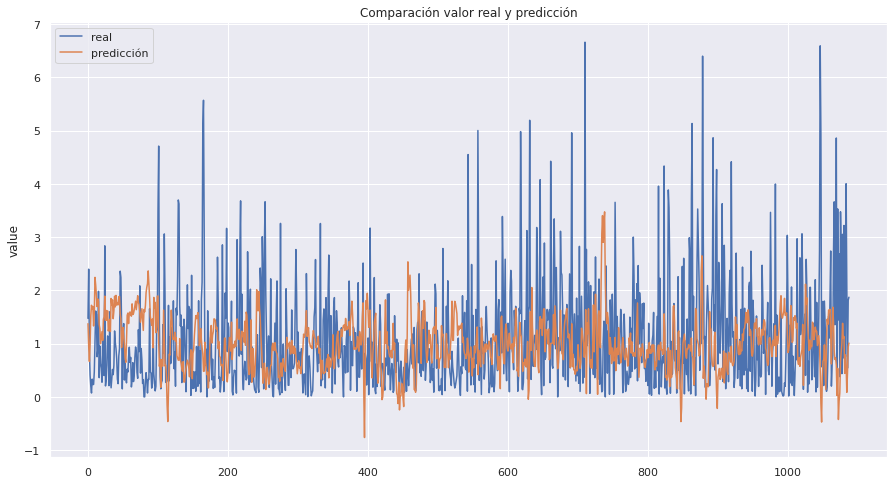

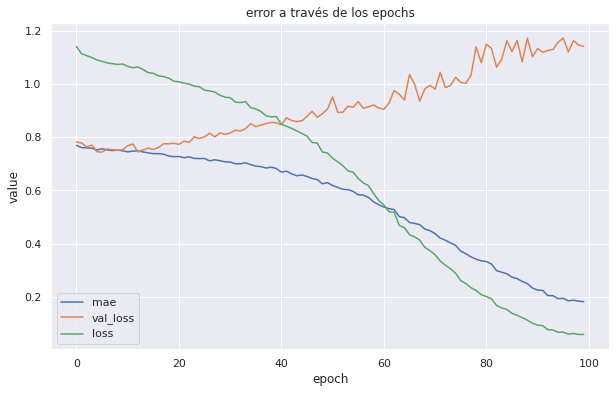

34/34 [==============================] - 0s 12ms/step
Evaluation metric results:
MSE is : 0.3432627326627716
MAE is : 0.33311783528593036
RMSE is : 0.5858862796334896
MAPE is : 17.69662208810607
Evaluation metric results:
MSE is : 1.2711215589630427
MAE is : 0.8615318555580099
RMSE is : 1.127440268467932
MAPE is : 46.99638310483859
(2547, 10, 6) (2547, 1)
(1086, 10, 6) (1086, 1)
Epoch 1/100
128/128 [==============================] - 3s 11ms/step - loss: 1.1959 - mae: 0.7946 - val_loss: 0.7928 - val_mae: 0.6794
Epoch 2/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1589 - mae: 0.7753 - val_loss: 0.7942 - val_mae: 0.6845
Epoch 3/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1440 - mae: 0.7694 - val_loss: 0.7954 - val_mae: 0.6883
Epoch 4/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1347 - mae: 0.7700 - val_loss: 0.7975 - val_mae: 0.6918
Epoch 5/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1278 - m

Epoch 59/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0355 - mae: 0.7370 - val_loss: 0.8006 - val_mae: 0.6945
Epoch 60/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0338 - mae: 0.7374 - val_loss: 0.8017 - val_mae: 0.6945
Epoch 61/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0325 - mae: 0.7367 - val_loss: 0.8008 - val_mae: 0.6933
Epoch 62/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0314 - mae: 0.7379 - val_loss: 0.8001 - val_mae: 0.6917
Epoch 63/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0317 - mae: 0.7349 - val_loss: 0.8005 - val_mae: 0.6922
Epoch 64/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0292 - mae: 0.7370 - val_loss: 0.8013 - val_mae: 0.6928
Epoch 65/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0285 - mae: 0.7332 - val_loss: 0.7999 - val_mae: 0.6911
Epoch 66/100
128/128 [==============================] - 1s 6ms

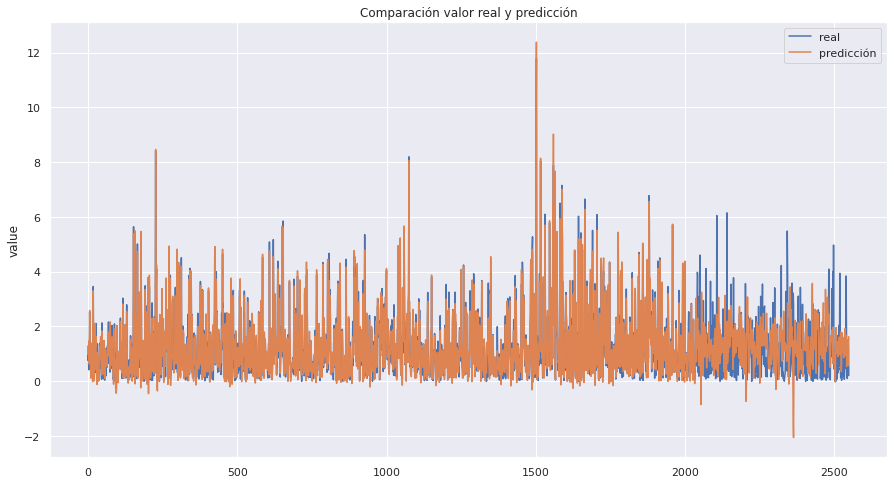

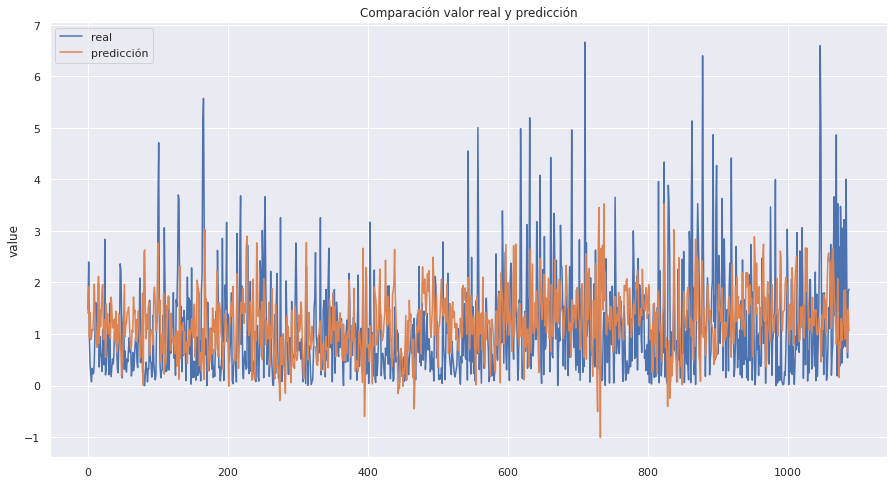

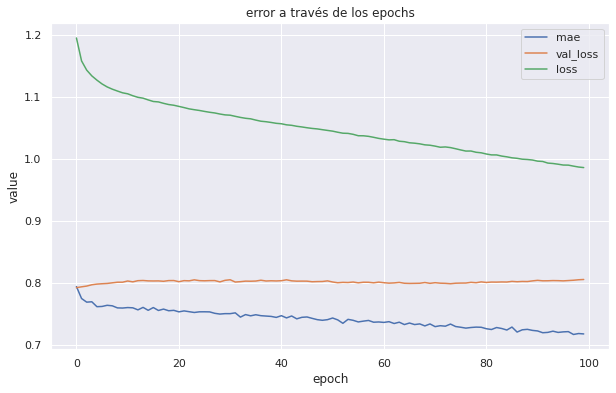

34/34 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.2261311320791373
MAE is : 0.8069072127120828
RMSE is : 1.1073080565403366
MAPE is : 39.637705835761174
Evaluation metric results:
MSE is : 1.0190779288446332
MAE is : 0.7655005423735359
RMSE is : 1.009493897378599
MAPE is : 40.583826632244566
(2547, 10, 6) (2547, 1)
(1086, 10, 6) (1086, 1)
Epoch 1/100
128/128 [==============================] - 4s 11ms/step - loss: 1.1736 - mae: 0.7668 - val_loss: 0.8393 - val_mae: 0.7136
Epoch 2/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1368 - mae: 0.7688 - val_loss: 0.8320 - val_mae: 0.7125
Epoch 3/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1256 - mae: 0.7658 - val_loss: 0.8298 - val_mae: 0.7114
Epoch 4/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1192 - mae: 0.7700 - val_loss: 0.8300 - val_mae: 0.7143
Epoch 5/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1153 - m

Epoch 59/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0092 - mae: 0.7286 - val_loss: 0.8449 - val_mae: 0.6777
Epoch 60/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0061 - mae: 0.7281 - val_loss: 0.8475 - val_mae: 0.6774
Epoch 61/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0042 - mae: 0.7283 - val_loss: 0.8472 - val_mae: 0.6763
Epoch 62/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0026 - mae: 0.7280 - val_loss: 0.8480 - val_mae: 0.6759
Epoch 63/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0025 - mae: 0.7246 - val_loss: 0.8478 - val_mae: 0.6764
Epoch 64/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9960 - mae: 0.7239 - val_loss: 0.8435 - val_mae: 0.6769
Epoch 65/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9969 - mae: 0.7241 - val_loss: 0.8502 - val_mae: 0.6751
Epoch 66/100
128/128 [==============================] - 1s 7ms

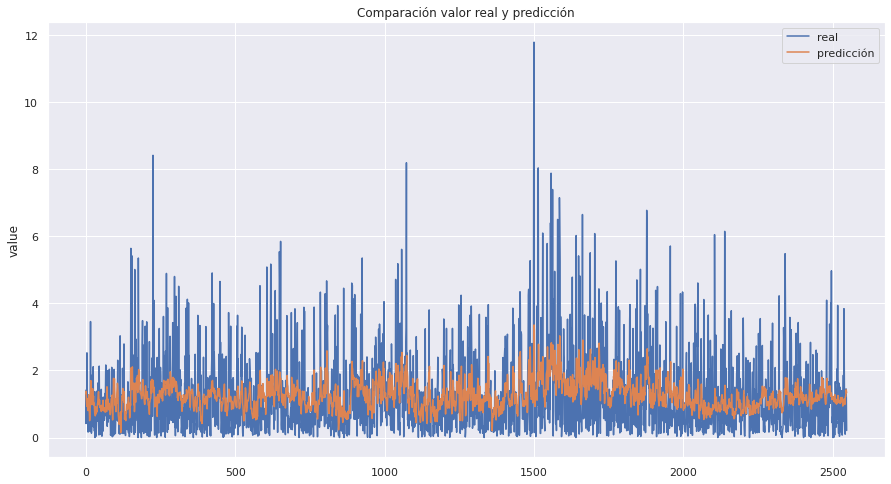

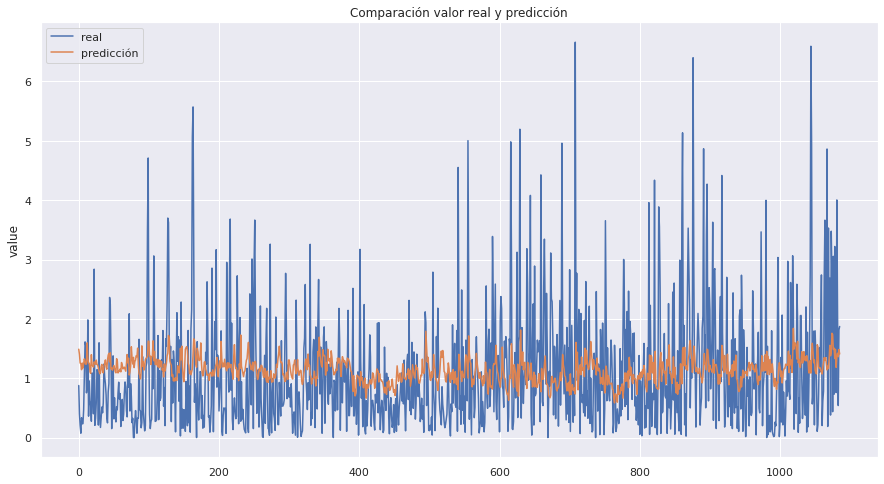

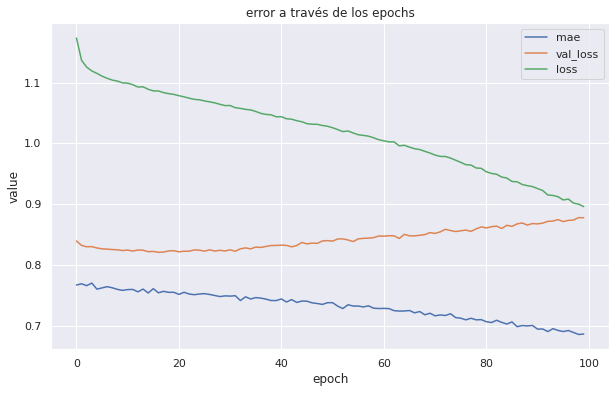

34/34 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.1437924019024894
MAE is : 0.76881270505435
RMSE is : 1.06948230555839
MAPE is : 36.77743829905475
Evaluation metric results:
MSE is : 1.0605982002028005
MAE is : 0.7637039682676053
RMSE is : 1.0298534848233512
MAPE is : 38.786358983882906
(2547, 10, 6) (2547, 1)
(1086, 10, 6) (1086, 1)
Epoch 1/100
128/128 [==============================] - 4s 11ms/step - loss: 1.1557 - mae: 0.7744 - val_loss: 0.8091 - val_mae: 0.7009
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1300 - mae: 0.7695 - val_loss: 0.8084 - val_mae: 0.7036
Epoch 3/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1190 - mae: 0.7634 - val_loss: 0.8045 - val_mae: 0.7011
Epoch 4/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1135 - mae: 0.7685 - val_loss: 0.8200 - val_mae: 0.7191
Epoch 5/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1102 - mae: 

Epoch 59/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9299 - mae: 0.7001 - val_loss: 0.7977 - val_mae: 0.6642
Epoch 60/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9231 - mae: 0.6979 - val_loss: 0.8007 - val_mae: 0.6668
Epoch 61/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9208 - mae: 0.6992 - val_loss: 0.7994 - val_mae: 0.6672
Epoch 62/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9146 - mae: 0.6973 - val_loss: 0.8024 - val_mae: 0.6635
Epoch 63/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9124 - mae: 0.6929 - val_loss: 0.8026 - val_mae: 0.6676
Epoch 64/100
128/128 [==============================] - 1s 7ms/step - loss: 0.9002 - mae: 0.6933 - val_loss: 0.8005 - val_mae: 0.6717
Epoch 65/100
128/128 [==============================] - 1s 7ms/step - loss: 0.8956 - mae: 0.6893 - val_loss: 0.8043 - val_mae: 0.6710
Epoch 66/100
128/128 [==============================] - 1s 7ms

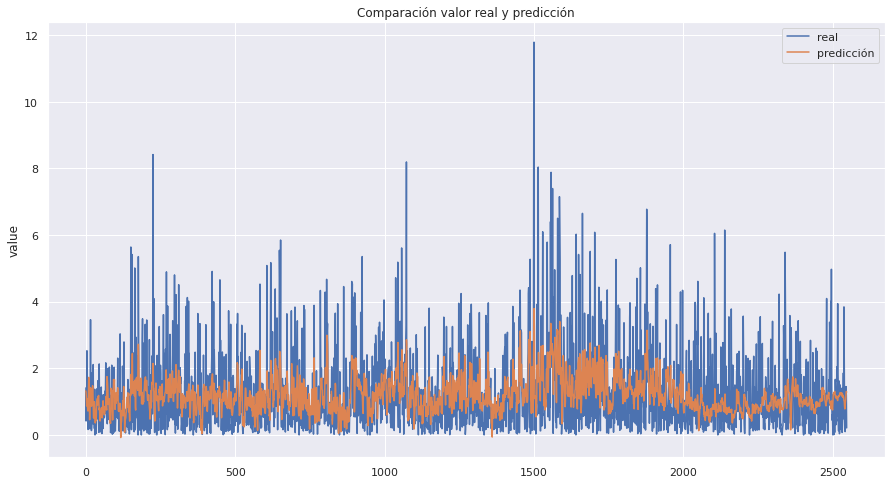

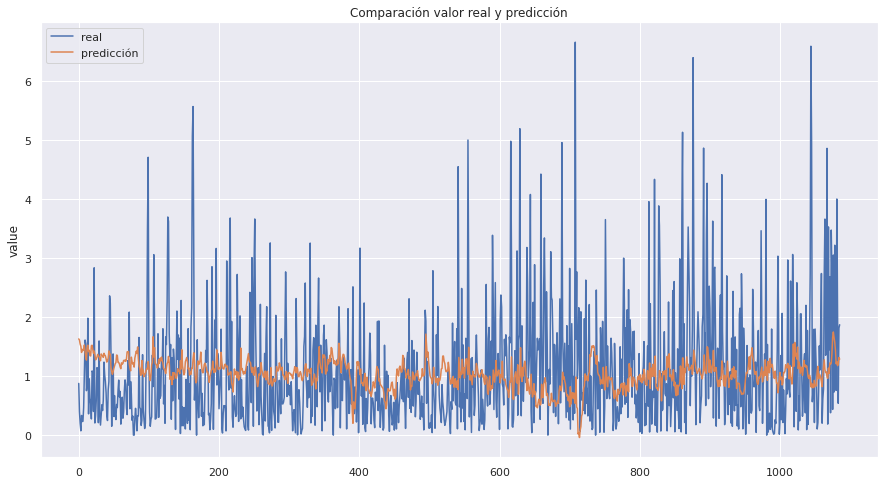

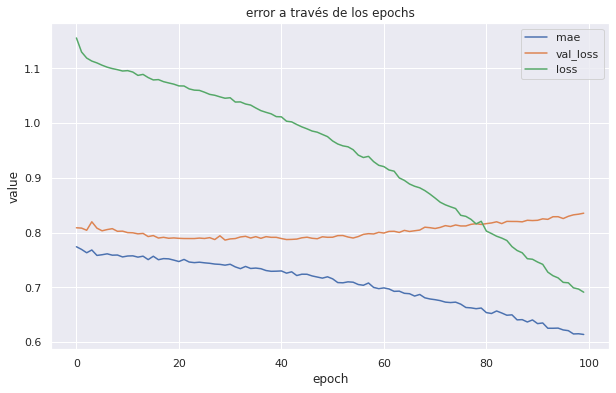

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 0.8966979298227422
MAE is : 0.6920821014379914
RMSE is : 0.9469413550071315
MAPE is : 33.6043903726237
Evaluation metric results:
MSE is : 1.0689219002129893
MAE is : 0.7736234902264553
RMSE is : 1.033886792745216
MAPE is : 40.12573951859724
(2547, 10, 6) (2547, 1)
(1086, 10, 6) (1086, 1)
Epoch 1/100
128/128 [==============================] - 5s 15ms/step - loss: 1.1388 - mae: 0.7683 - val_loss: 0.7961 - val_mae: 0.6858
Epoch 2/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1209 - mae: 0.7679 - val_loss: 0.7928 - val_mae: 0.6905
Epoch 3/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1120 - mae: 0.7615 - val_loss: 0.7893 - val_mae: 0.6856
Epoch 4/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1074 - mae: 0.7659 - val_loss: 0.8040 - val_mae: 0.7073
Epoch 5/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1047 - 

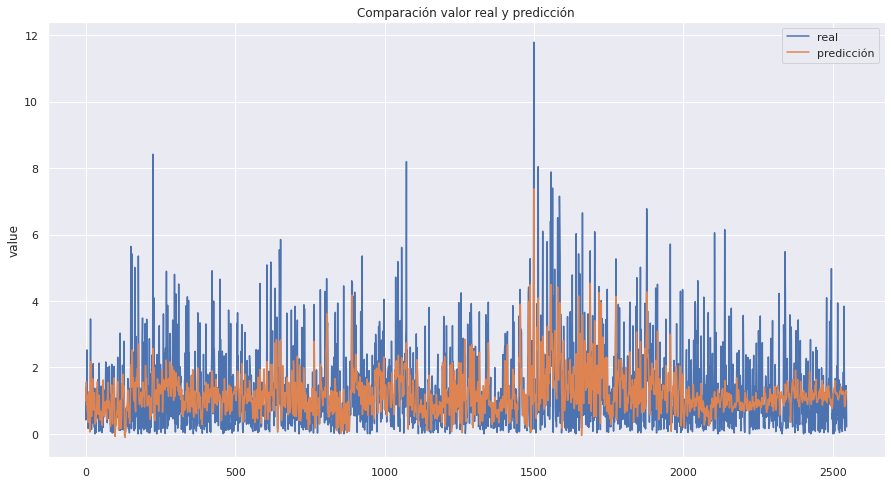

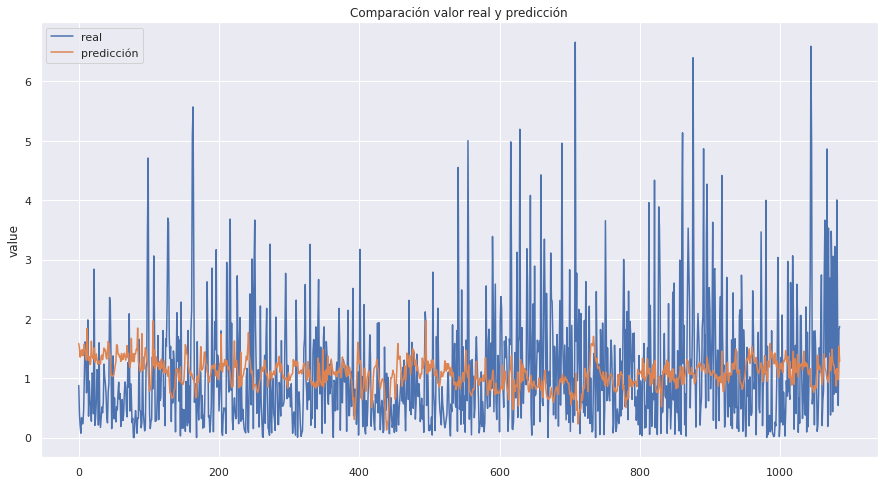

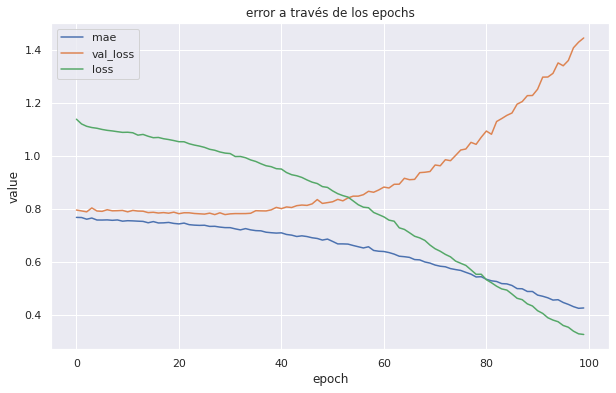

34/34 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 0.6758340632368457
MAE is : 0.5702697964329957
RMSE is : 0.822091274273633
MAPE is : 28.374310517682883
Evaluation metric results:
MSE is : 1.9197115103613782
MAE is : 1.0596783279745805
RMSE is : 1.3855365424128583
MAPE is : 54.23135924408883
(2547, 10, 6) (2547, 1)
(1086, 10, 6) (1086, 1)
Epoch 1/100
128/128 [==============================] - 5s 21ms/step - loss: 1.1483 - mae: 0.7738 - val_loss: 0.7984 - val_mae: 0.6763
Epoch 2/100
128/128 [==============================] - 2s 16ms/step - loss: 1.1216 - mae: 0.7684 - val_loss: 0.7888 - val_mae: 0.6830
Epoch 3/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1110 - mae: 0.7614 - val_loss: 0.7822 - val_mae: 0.6697
Epoch 4/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1056 - mae: 0.7644 - val_loss: 0.7881 - val_mae: 0.6934
Epoch 5/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1006 

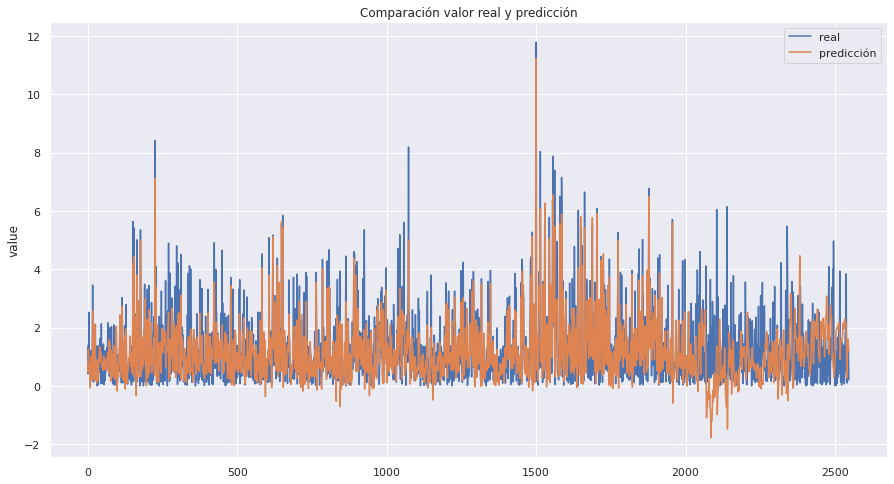

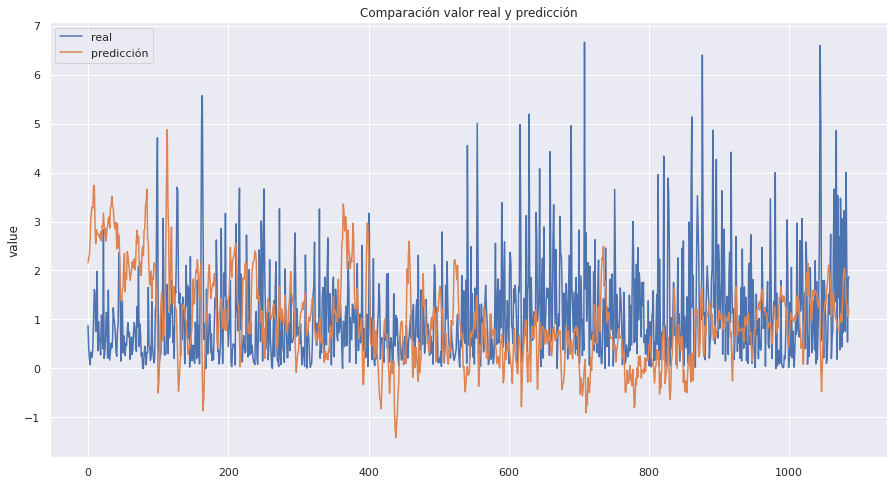

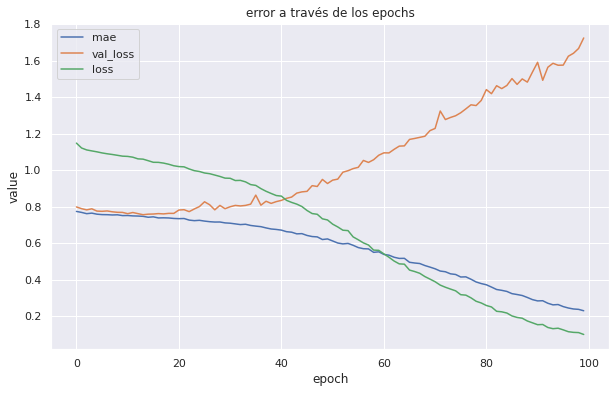

34/34 [==============================] - 0s 7ms/step
Evaluation metric results:
MSE is : 0.5302045814125776
MAE is : 0.40556213098562816
RMSE is : 0.7281514824626656
MAPE is : 21.150417981151183
Evaluation metric results:
MSE is : 1.45429513870644
MAE is : 0.8867072696008005
RMSE is : 1.205941598381298
MAPE is : 44.34550686493183
(2547, 10, 6) (2547, 1)
(1086, 10, 6) (1086, 1)
Epoch 1/100
128/128 [==============================] - 8s 37ms/step - loss: 1.1512 - mae: 0.7744 - val_loss: 0.7885 - val_mae: 0.6729
Epoch 2/100
128/128 [==============================] - 4s 32ms/step - loss: 1.1160 - mae: 0.7652 - val_loss: 0.7770 - val_mae: 0.6820
Epoch 3/100
128/128 [==============================] - 4s 33ms/step - loss: 1.1058 - mae: 0.7597 - val_loss: 0.7649 - val_mae: 0.6654
Epoch 4/100
128/128 [==============================] - 4s 32ms/step - loss: 1.0985 - mae: 0.7613 - val_loss: 0.7769 - val_mae: 0.6947
Epoch 5/100
128/128 [==============================] - 4s 32ms/step - loss: 1.0930 -

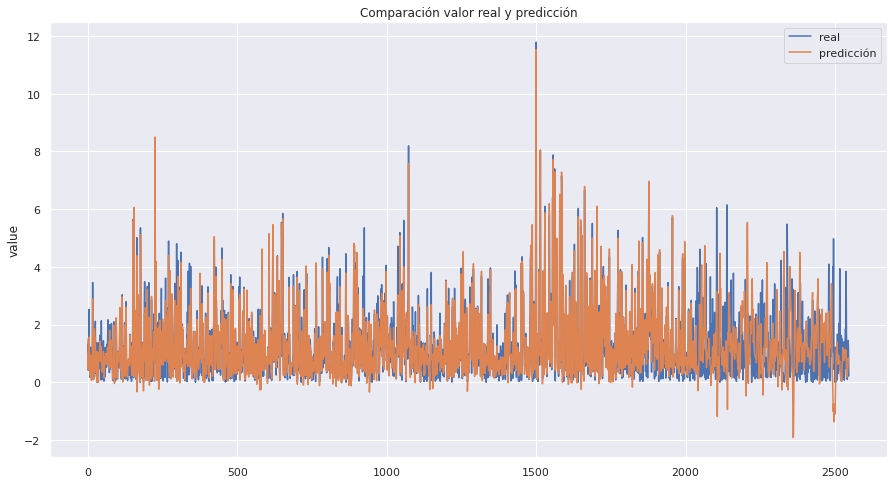

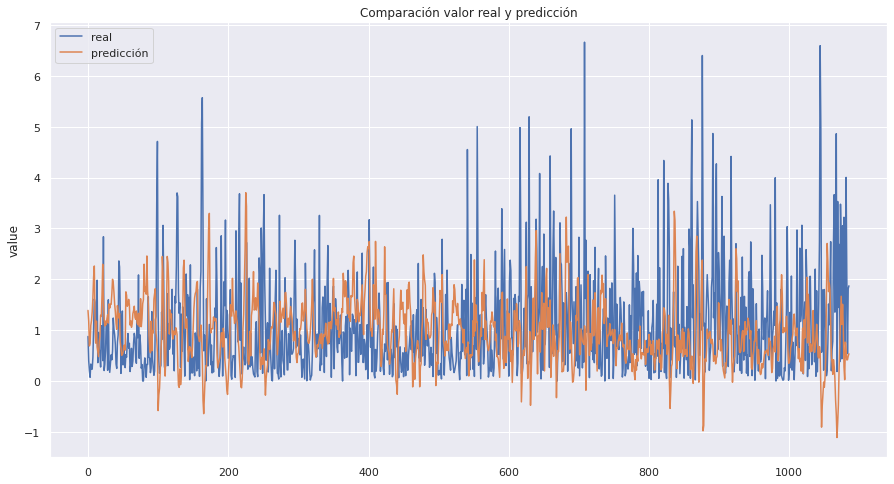

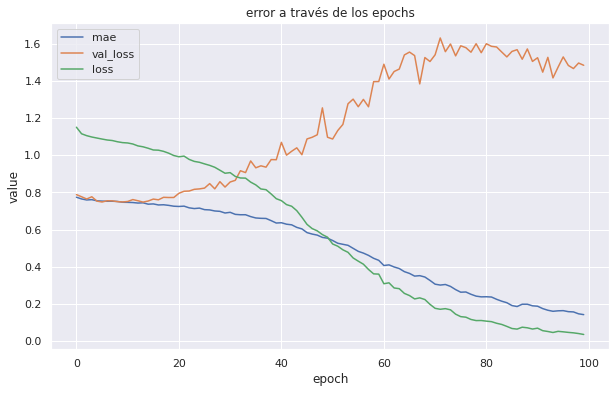

34/34 [==============================] - 0s 13ms/step
Evaluation metric results:
MSE is : 0.4174215421978701
MAE is : 0.3283863616938552
RMSE is : 0.646081683843359
MAPE is : 17.21634393316325
Evaluation metric results:
MSE is : 1.385637068238242
MAE is : 0.8861364854160808
RMSE is : 1.1771308628348176
MAPE is : 45.94500655183836
(2542, 15, 6) (2542, 1)
(1081, 15, 6) (1081, 1)
Epoch 1/100
128/128 [==============================] - 4s 12ms/step - loss: 1.1724 - mae: 0.7767 - val_loss: 0.7855 - val_mae: 0.6775
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1461 - mae: 0.7735 - val_loss: 0.7854 - val_mae: 0.6773
Epoch 3/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1348 - mae: 0.7648 - val_loss: 0.7849 - val_mae: 0.6773
Epoch 4/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1254 - mae: 0.7691 - val_loss: 0.7853 - val_mae: 0.6785
Epoch 5/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1191 - mae

Epoch 59/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0380 - mae: 0.7354 - val_loss: 0.7964 - val_mae: 0.6701
Epoch 60/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0376 - mae: 0.7355 - val_loss: 0.7963 - val_mae: 0.6697
Epoch 61/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0360 - mae: 0.7371 - val_loss: 0.7963 - val_mae: 0.6700
Epoch 62/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0363 - mae: 0.7337 - val_loss: 0.7964 - val_mae: 0.6697
Epoch 63/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0360 - mae: 0.7352 - val_loss: 0.7963 - val_mae: 0.6697
Epoch 64/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0348 - mae: 0.7356 - val_loss: 0.7964 - val_mae: 0.6694
Epoch 65/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0342 - mae: 0.7346 - val_loss: 0.7962 - val_mae: 0.6690
Epoch 66/100
128/128 [==============================] - 1s 8ms

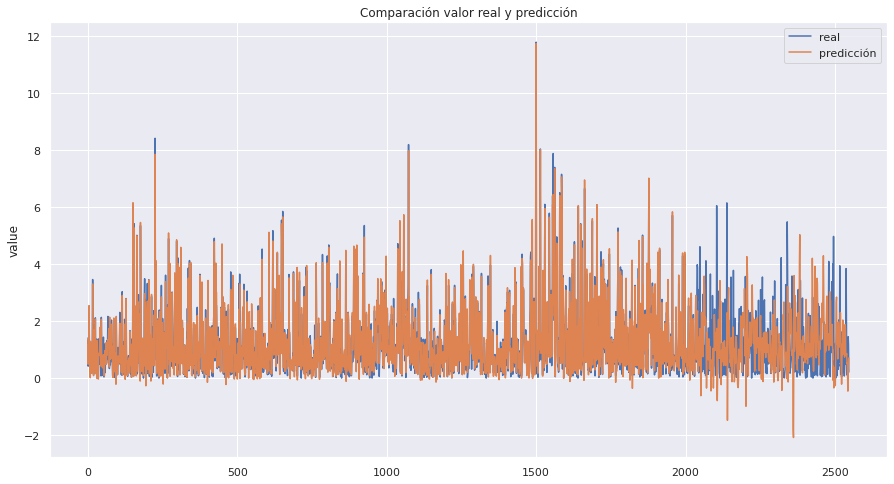

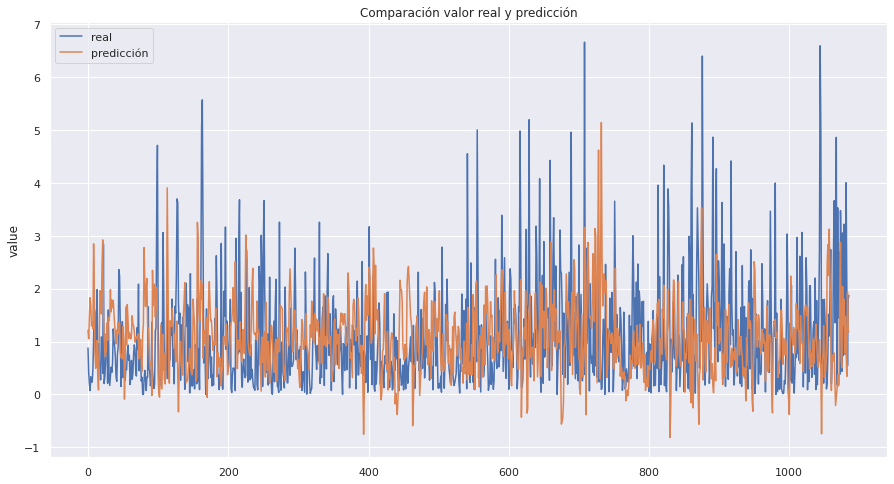

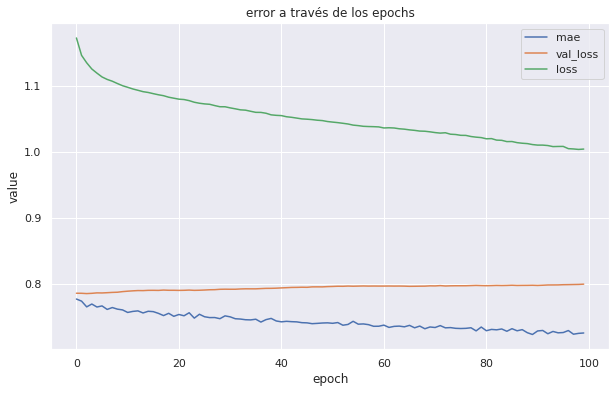

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.242927263221006
MAE is : 0.8101579583084665
RMSE is : 1.114866477754626
MAPE is : 39.76563075222961
Evaluation metric results:
MSE is : 1.0007226906009605
MAE is : 0.7369872884959783
RMSE is : 1.000361280038847
MAPE is : 37.69802940991603
(2542, 15, 6) (2542, 1)
(1081, 15, 6) (1081, 1)
Epoch 1/100
128/128 [==============================] - 5s 13ms/step - loss: 1.1715 - mae: 0.7617 - val_loss: 0.9868 - val_mae: 0.8420
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1318 - mae: 0.7702 - val_loss: 0.9546 - val_mae: 0.8224
Epoch 3/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1208 - mae: 0.7607 - val_loss: 0.9303 - val_mae: 0.8066
Epoch 4/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1134 - mae: 0.7667 - val_loss: 0.9259 - val_mae: 0.8026
Epoch 5/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1097 - mae: 

Epoch 59/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0074 - mae: 0.7300 - val_loss: 0.8277 - val_mae: 0.7196
Epoch 60/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0063 - mae: 0.7268 - val_loss: 0.8292 - val_mae: 0.7205
Epoch 61/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0031 - mae: 0.7300 - val_loss: 0.8279 - val_mae: 0.7190
Epoch 62/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0035 - mae: 0.7239 - val_loss: 0.8264 - val_mae: 0.7178
Epoch 63/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0038 - mae: 0.7296 - val_loss: 0.8306 - val_mae: 0.7215
Epoch 64/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0017 - mae: 0.7255 - val_loss: 0.8263 - val_mae: 0.7159
Epoch 65/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0003 - mae: 0.7254 - val_loss: 0.8267 - val_mae: 0.7173
Epoch 66/100
128/128 [==============================] - 1s 9ms

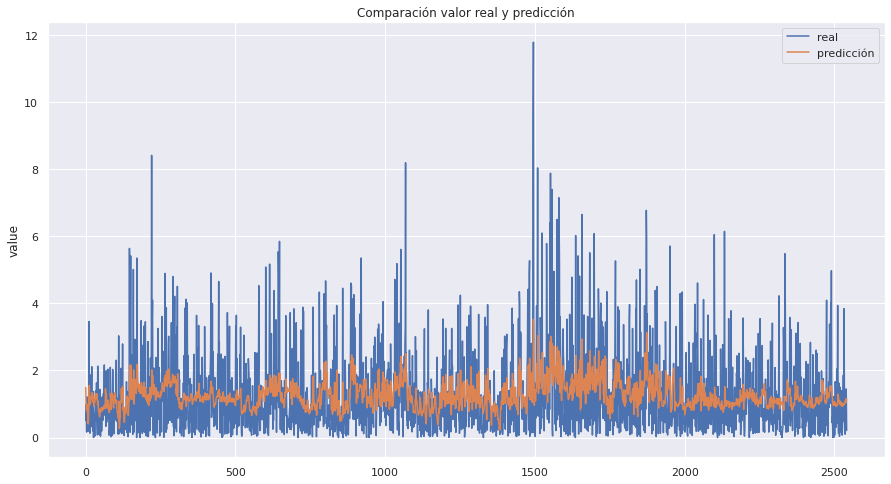

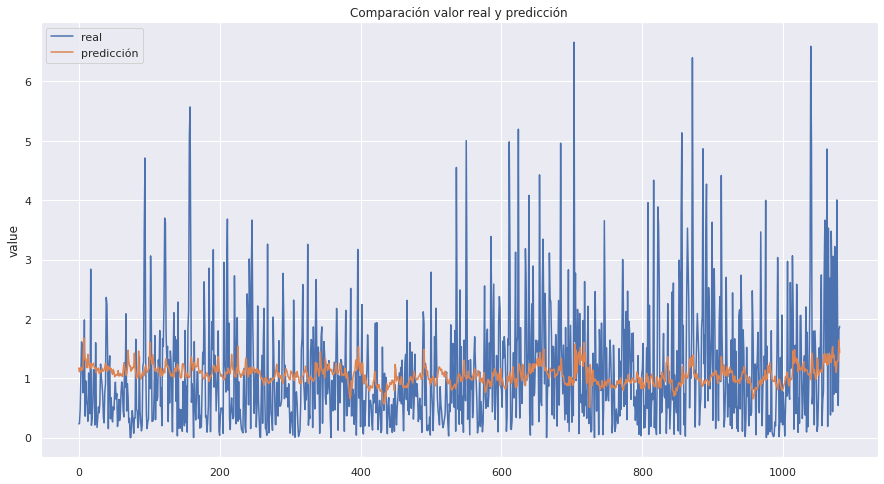

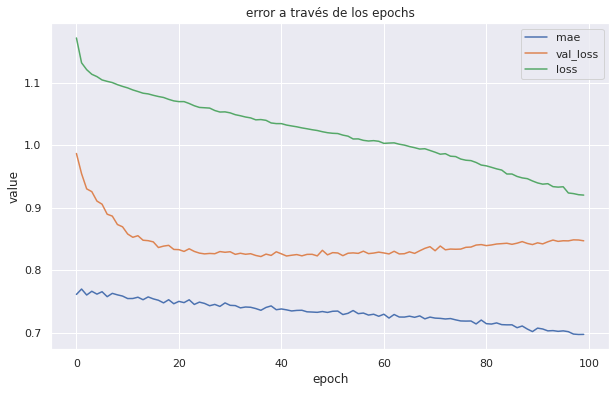

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.1613470703573507
MAE is : 0.7927491520265465
RMSE is : 1.0776581416930653
MAPE is : 39.1850953483527
Evaluation metric results:
MSE is : 1.149318240481216
MAE is : 0.8564461080885558
RMSE is : 1.0720626103363626
MAPE is : 48.98827603921277
(2542, 15, 6) (2542, 1)
(1081, 15, 6) (1081, 1)
Epoch 1/100
128/128 [==============================] - 4s 14ms/step - loss: 1.1487 - mae: 0.7682 - val_loss: 0.8357 - val_mae: 0.7344
Epoch 2/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1218 - mae: 0.7761 - val_loss: 0.8280 - val_mae: 0.7279
Epoch 3/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1112 - mae: 0.7577 - val_loss: 0.8112 - val_mae: 0.7142
Epoch 4/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1100 - mae: 0.7687 - val_loss: 0.8223 - val_mae: 0.7242
Epoch 5/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1059 - 

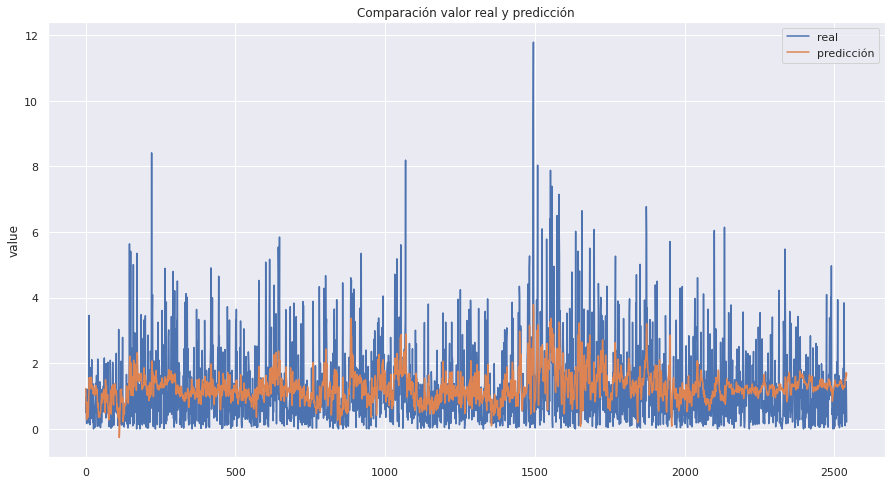

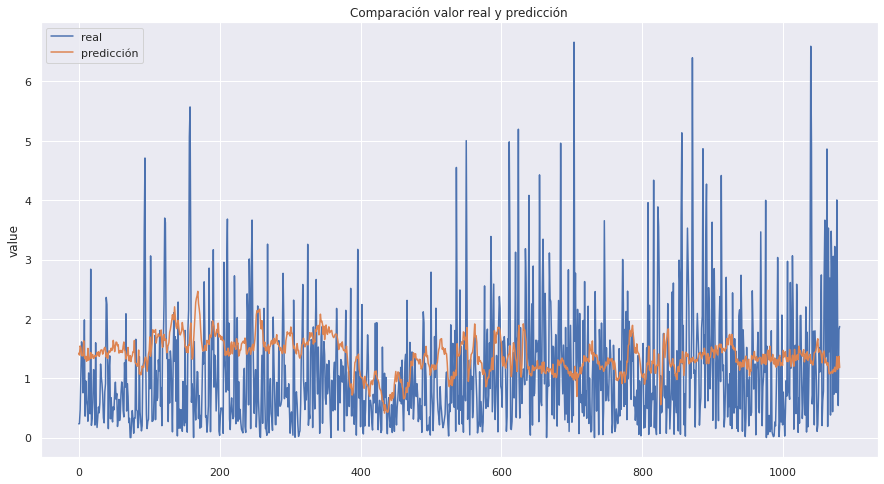

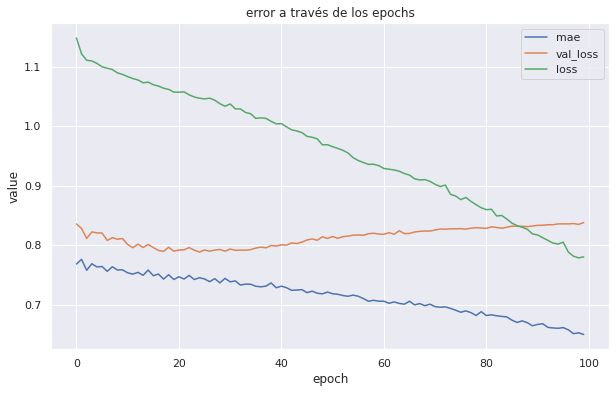

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.0049453369881256
MAE is : 0.7379600006674873
RMSE is : 1.002469618985097
MAPE is : 35.94219160620908
Evaluation metric results:
MSE is : 1.0329380996731867
MAE is : 0.7668724340060605
RMSE is : 1.0163356235383991
MAPE is : 40.60864876357913
(2542, 15, 6) (2542, 1)
(1081, 15, 6) (1081, 1)
Epoch 1/100
128/128 [==============================] - 5s 18ms/step - loss: 1.1491 - mae: 0.7710 - val_loss: 0.8033 - val_mae: 0.6880
Epoch 2/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1196 - mae: 0.7767 - val_loss: 0.7897 - val_mae: 0.6814
Epoch 3/100
128/128 [==============================] - 2s 13ms/step - loss: 1.0997 - mae: 0.7545 - val_loss: 0.7926 - val_mae: 0.6773
Epoch 4/100
128/128 [==============================] - 2s 13ms/step - loss: 1.0997 - mae: 0.7643 - val_loss: 0.7927 - val_mae: 0.6893
Epoch 5/100
128/128 [==============================] - 2s 13ms/step - loss: 1.0949 -

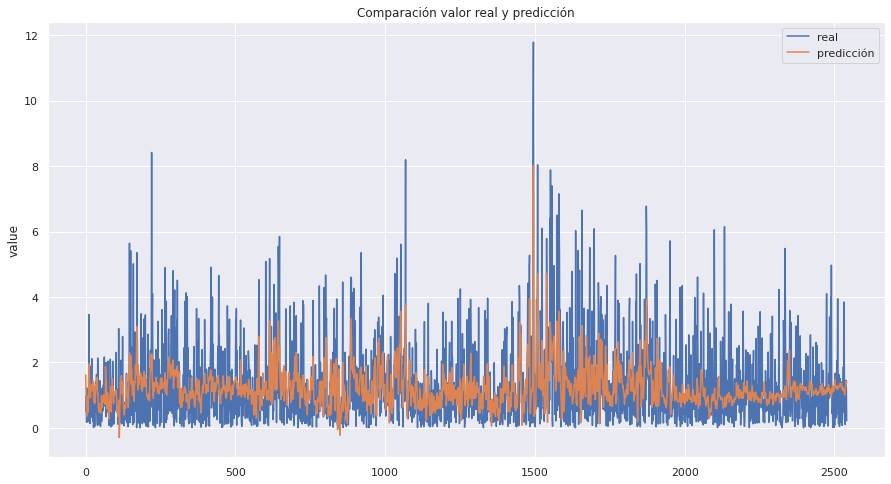

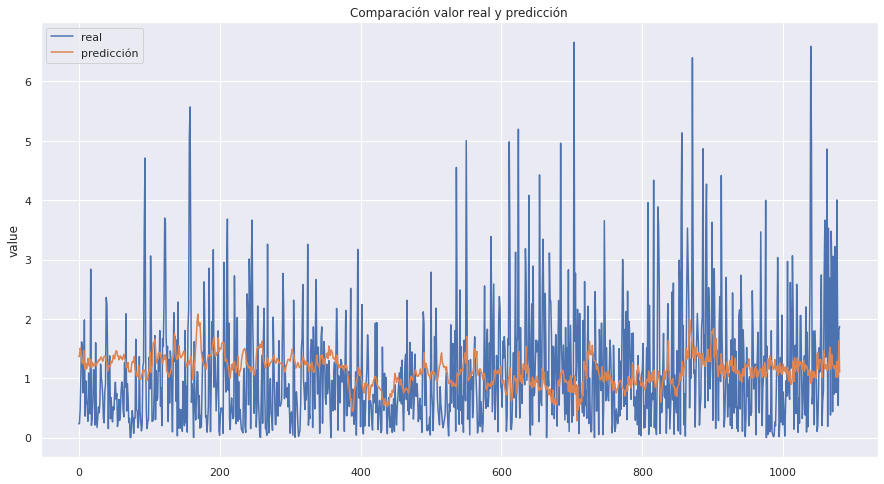

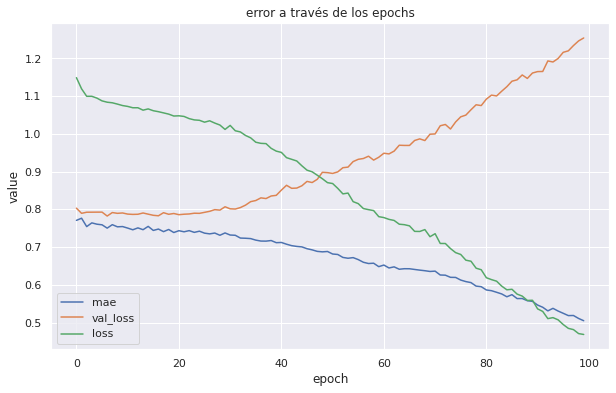

34/34 [==============================] - 0s 9ms/step
Evaluation metric results:
MSE is : 0.7667730763325156
MAE is : 0.6327569702354414
RMSE is : 0.8756557978638156
MAPE is : 31.545599541836427
Evaluation metric results:
MSE is : 1.605303499705821
MAE is : 0.968006274557196
RMSE is : 1.2670057220493605
MAPE is : 51.71240936786208
(2542, 15, 6) (2542, 1)
(1081, 15, 6) (1081, 1)
Epoch 1/100
128/128 [==============================] - 6s 27ms/step - loss: 1.1520 - mae: 0.7699 - val_loss: 0.8109 - val_mae: 0.7030
Epoch 2/100
128/128 [==============================] - 3s 23ms/step - loss: 1.1162 - mae: 0.7734 - val_loss: 0.7896 - val_mae: 0.6944
Epoch 3/100
128/128 [==============================] - 3s 23ms/step - loss: 1.0935 - mae: 0.7528 - val_loss: 0.7949 - val_mae: 0.6909
Epoch 4/100
128/128 [==============================] - 3s 23ms/step - loss: 1.0968 - mae: 0.7611 - val_loss: 0.7962 - val_mae: 0.7030
Epoch 5/100
128/128 [==============================] - 3s 23ms/step - loss: 1.0965 -

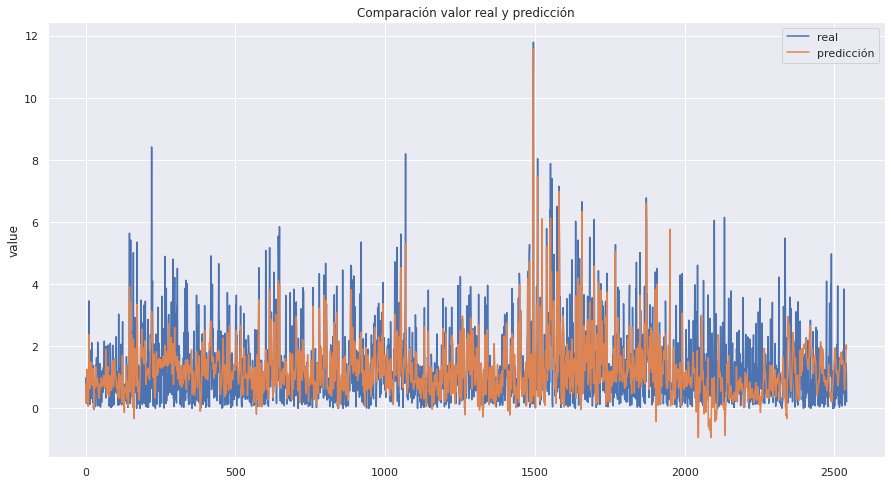

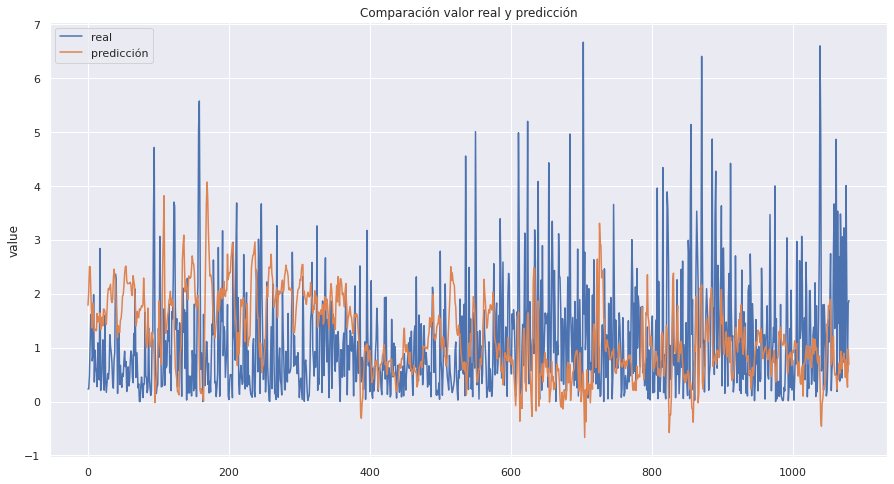

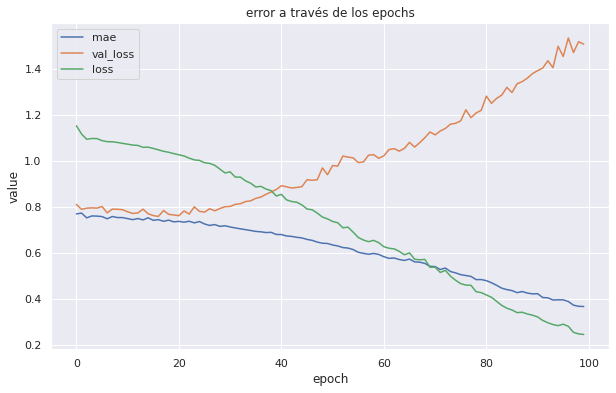

34/34 [==============================] - 0s 10ms/step
Evaluation metric results:
MSE is : 0.611905832926011
MAE is : 0.5153979729229476
RMSE is : 0.7822441006016031
MAPE is : 26.178089743322207
Evaluation metric results:
MSE is : 1.7829684863425403
MAE is : 1.0236222560547321
RMSE is : 1.3352784302693355
MAPE is : 56.7554793061931
(2542, 15, 6) (2542, 1)
(1081, 15, 6) (1081, 1)
Epoch 1/100
128/128 [==============================] - 10s 49ms/step - loss: 1.1522 - mae: 0.7691 - val_loss: 0.7914 - val_mae: 0.6887
Epoch 2/100
128/128 [==============================] - 6s 44ms/step - loss: 1.1146 - mae: 0.7722 - val_loss: 0.7694 - val_mae: 0.6817
Epoch 3/100
128/128 [==============================] - 6s 44ms/step - loss: 1.0903 - mae: 0.7519 - val_loss: 0.7809 - val_mae: 0.6781
Epoch 4/100
128/128 [==============================] - 6s 44ms/step - loss: 1.0931 - mae: 0.7587 - val_loss: 0.7749 - val_mae: 0.6897
Epoch 5/100
128/128 [==============================] - 6s 44ms/step - loss: 1.0952

In [ ]:
lags=[5,8,10,15]
neuronss=[16,32,64,128,256,512]
results_models={i:{} for i in lags}
for lg in lags:
    for neuron in neuronss:
        results_models[lg][neuron]=Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=neuron,attributes=6,epochss=100,batch_sizze=16,lag=lg)

In [ ]:
import json
path="./resultsLSTM/volatilidadVariablesNoticiasAntes/"

In [ ]:
for i in lags:
    with open(path+f"lag{i}.json", "w") as outfile:
        json.dump(results_models[i], outfile)

(2542, 15, 6) (2542, 1)
(1081, 15, 6) (1081, 1)
Epoch 1/100
128/128 [==============================] - 4s 13ms/step - loss: 1.1670 - mae: 0.7771 - val_loss: 0.8158 - val_mae: 0.6922
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1274 - mae: 0.7778 - val_loss: 0.8097 - val_mae: 0.6907
Epoch 3/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1138 - mae: 0.7573 - val_loss: 0.8132 - val_mae: 0.6875
Epoch 4/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1117 - mae: 0.7683 - val_loss: 0.8107 - val_mae: 0.6962
Epoch 5/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1071 - mae: 0.7634 - val_loss: 0.8124 - val_mae: 0.7007
Epoch 6/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1011 - mae: 0.7638 - val_loss: 0.8143 - val_mae: 0.7034
Epoch 7/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0987 - mae: 0.7555 - val_loss: 0.8058 - val_mae: 0.6917
Epoch 8/100
128/128 

Epoch 62/100
128/128 [==============================] - 1s 10ms/step - loss: 0.9254 - mae: 0.6977 - val_loss: 0.8593 - val_mae: 0.6959
Epoch 63/100
128/128 [==============================] - 1s 9ms/step - loss: 0.9242 - mae: 0.7006 - val_loss: 0.8573 - val_mae: 0.6975
Epoch 64/100
128/128 [==============================] - 1s 10ms/step - loss: 0.9212 - mae: 0.6990 - val_loss: 0.8626 - val_mae: 0.6938
Epoch 65/100
128/128 [==============================] - 1s 9ms/step - loss: 0.9177 - mae: 0.6973 - val_loss: 0.8594 - val_mae: 0.6976
Epoch 66/100
128/128 [==============================] - 1s 10ms/step - loss: 0.9136 - mae: 0.7002 - val_loss: 0.8617 - val_mae: 0.6990
Epoch 67/100
128/128 [==============================] - 1s 9ms/step - loss: 0.9062 - mae: 0.6948 - val_loss: 0.8635 - val_mae: 0.6983
Epoch 68/100
128/128 [==============================] - 1s 9ms/step - loss: 0.9032 - mae: 0.6947 - val_loss: 0.8633 - val_mae: 0.6982
Epoch 69/100
128/128 [==============================] - 1s 

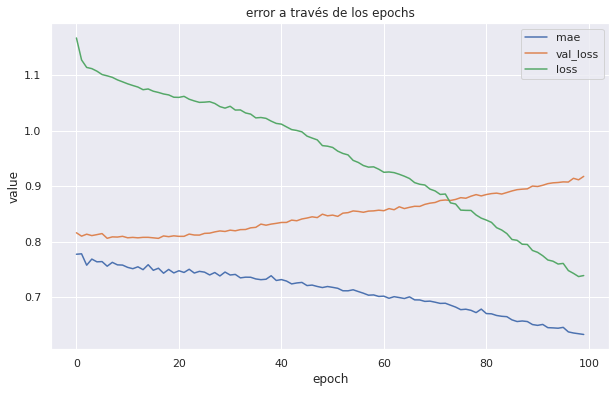

34/34 [==============================] - 0s 3ms/step


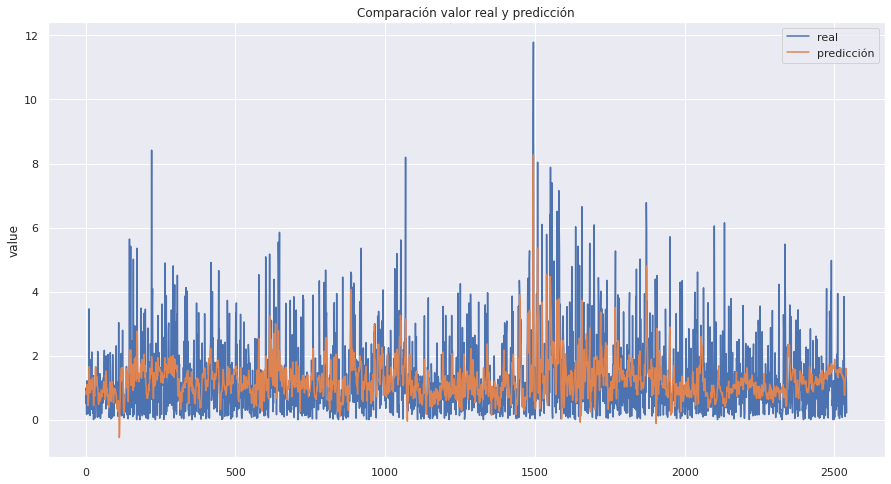

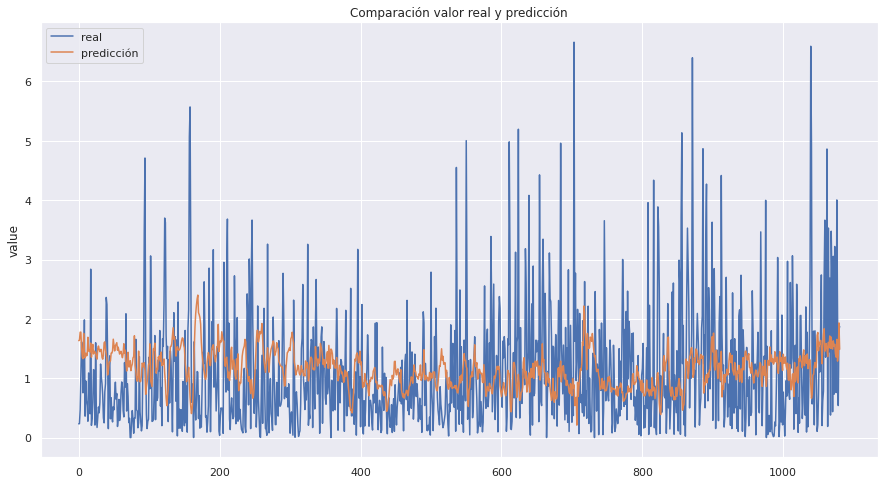

In [13]:
tessst=Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=64,attributes=6,epochss=100,batch_sizze=16,lag=15)
pd.concat([pd.DataFrame(tessst[0]),pd.DataFrame(tessst[1])])
pd.merge(df_stats,pd.concat([pd.DataFrame(tessst[0]),pd.DataFrame(tessst[1])]),how="left",on="Fecha").to_csv("VolatilidadVariablesNoticiasAntes.csv",index=False)